In [1]:
%load_ext notexbook
%texify -v

## $\alpha \Omega$ Dynamo Equation using Crank Nicholson without Ghost Zones

This notebook will illustrate the crank nicholson difference method solving Galactic $\alpha \Omega$ Dynamo Equation.

## Crank-Nicolson Difference method

The implicit Crank-Nicolson difference equation of the Dynamo equation
is derived by discretising the following coupled equations

$$
\frac{\partial \bar{B}_r}{\partial t} = - \alpha \frac{\partial }{\partial z} (\bar{B}_{\phi}) + \frac{\partial^2 \bar{B}_r}{\partial z^2}
$$

$$
\frac{\partial \bar{B}_\phi}{\partial t} =  DS\bar{B}_r + \frac{\partial^2 \bar{B}_\phi}{\partial z^2} 
$$

Where $\alpha , D , S$ are currently constant parameters for this system.

In [2]:
import numpy as np
from tabulate import tabulate
from PIL import Image

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
from matplotlib.animation import FuncAnimation
from IPython import display

from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['grid.alpha'] = 0.5
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# galactic constants
km = 1*10**3
pc = 3.086*10**16
Myr = 1e6*365*24*3600

## Discrete Grid

1. **Spatial Discretization**:

   We divide the spatial domain  $z$ into $N$ grid points. Let $h$ denote the spacing between consecutive grid points.

2. **Time Discretization**:

   We discretize the time domain $t$ into time steps of size $k$.

The region $\Omega$ is discretised into a uniform mesh $\Omega_h$. In the space $x$ direction into $N$ steps giving a stepsize of

$$ h=\frac{1-0}{N} $$
resulting in 

$$ x[i]=0+ih, \ \ \  i=0,1,...,N, $$

and into $N_t$ steps in the time $t$ direction giving a stepsize of

$$ k=\frac{1-0}{N_t} $$
resulting in 

$$ t[i]=0+ik, \ \ \ k=0,...,K.$$
The Figure below shows the discrete grid points for $N$ space points and $N_t$ time points , the <font color = 'red'> <b>red</b> </font> dots are the unknown values, the <font color = 'green'> <b>green</b> </font> dots are the known boundary conditions and the <font color = 'blue'> <b>blue</b> </font> dots are the known initial conditions of the diffusion Equation. Additionally, ghost zones are included at the first and last indices. These ghost zones are crucial for defining derivatives at the boundary.



In [3]:
# Parameters 
h = 7                               # 100pc
eta_T = 1                           # magnetic diffusivity 
Omega = 100*Myr*km/(1000*pc)        # angular velocity
q = 1                               # shear paramete
alpha_0 = 4/h                       # alpha effect
N = 200
Nt = 200
dz = 2 / N
dt = 2 / Nt
time_steps = 200
time = np.arange(0, (time_steps + 0.5) * dt, dt)
z = np.arange(-1.00, 1.0001, dz) 
Z, Y = np.meshgrid(z, time)

In [4]:
data = [
    ['Parameter', 'Value'],
    ['eta', eta_T],
    ['alpha', alpha_0],
    ['omega', Omega],
    ['Rw', -q*Omega*h**2/eta_T],
    ['Ra', alpha_0*h/eta_T],
    ['Dynamo number', -alpha_0*q*Omega*h**3/eta_T**2]
]

print(tabulate(data, tablefmt='fancy_grid'))

╒═══════════════╤═════════════════════╕
│ Parameter     │ Value               │
├───────────────┼─────────────────────┤
│ eta           │ 1                   │
├───────────────┼─────────────────────┤
│ alpha         │ 0.5714285714285714  │
├───────────────┼─────────────────────┤
│ omega         │ 0.10219053791315619 │
├───────────────┼─────────────────────┤
│ Rw            │ -5.007336357744653  │
├───────────────┼─────────────────────┤
│ Ra            │ 4.0                 │
├───────────────┼─────────────────────┤
│ Dynamo number │ -20.029345430978612 │
╘═══════════════╧═════════════════════╛


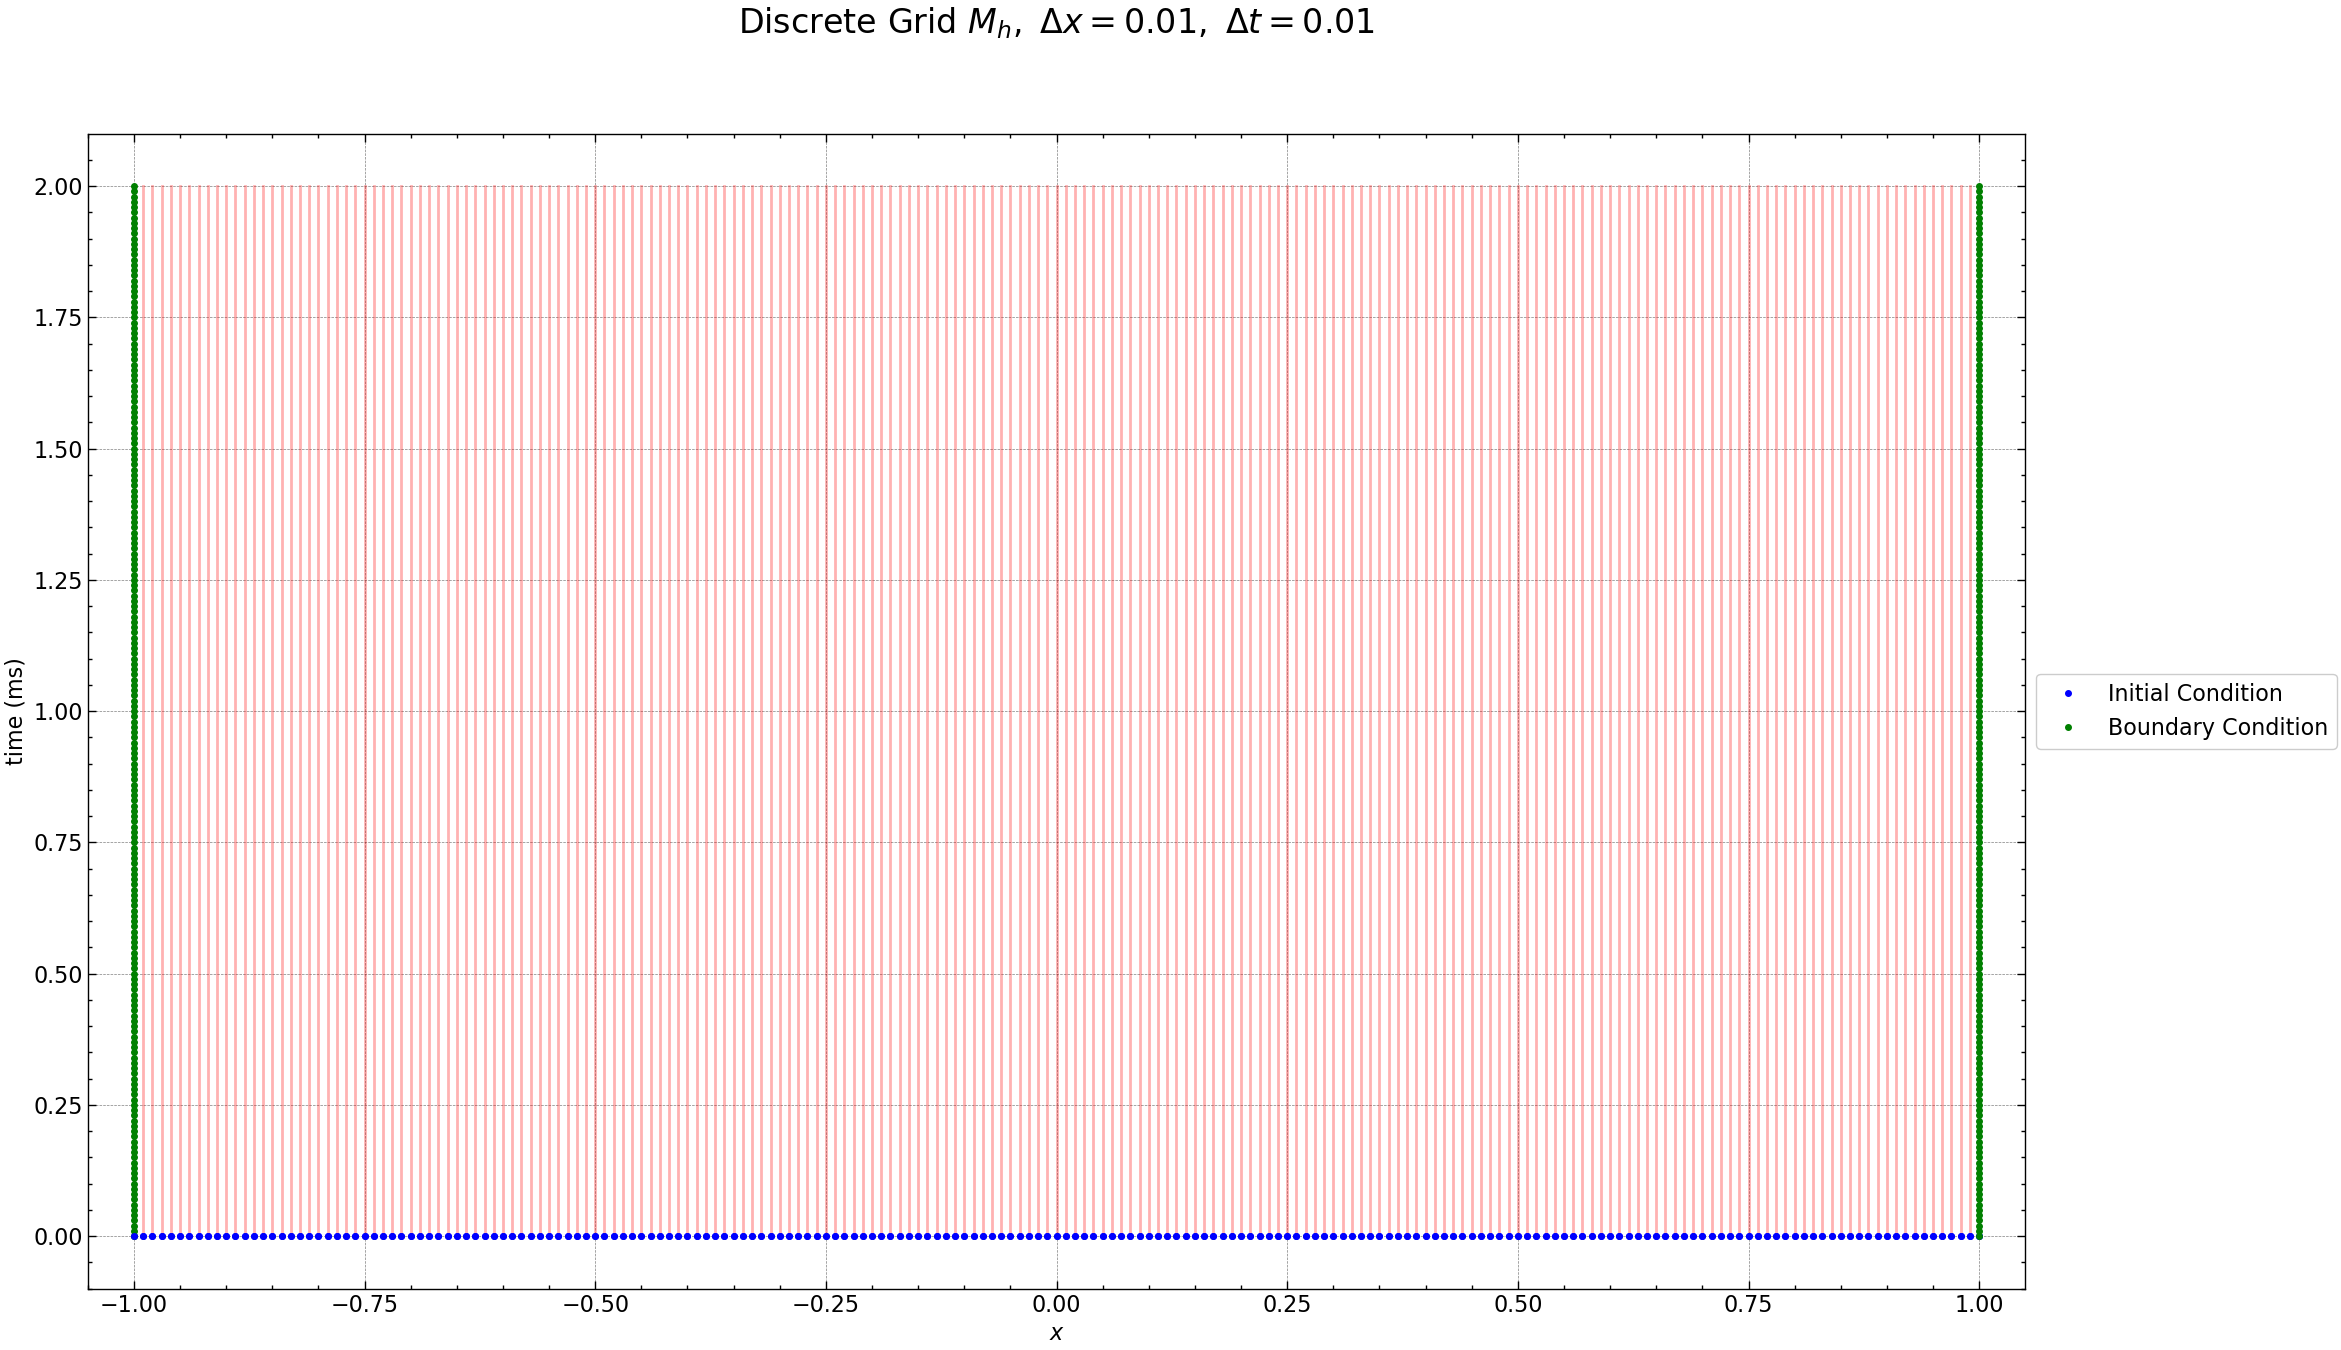

In [5]:
fig = plt.figure(figsize=(25, 15))
plt.plot(Z, Y, 'r-', alpha=0.3)  
plt.plot(z, 0 * z, 'bo', markersize=4, label='Initial Condition')  
plt.plot(np.ones(time_steps + 1) * -1, time, 'go', markersize=4, label='Boundary Condition')  
plt.plot(z, 0 * z, 'bo', markersize=4)
plt.plot(np.ones(time_steps + 1) * 1, time, 'go', markersize=4)
plt.xlim((-1.05, 1.05))  
plt.xlabel(r'$x$')
plt.ylabel(r'time (ms)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Discrete Grid $M_h,$ $\Delta x= %s,$ $\Delta t=%s$' % (dz, dt), fontsize=24, y=1.08)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("results/grid.png")
plt.show()

<div align="center"><font color='blue'><h2>Seed 1: Oscillatory Solution</h2></font></div>

$$ B_r = B_o cos(\frac{3}{2} \pi z) $$
$$ B_r = B_o cos(\frac{1}{2} \pi z) $$

## Initial and Boundary Conditions

### Vacuum Boundary Conditions

At $|z| = h$ for a disc-shaped magnetized system, continuity of magnetic field components requires $B_{\phi} = 0$ and $B_r \approx 0$ at $z = \pm h$. These exact conditions, known as *vacuum boundary conditions*, are due to axial symmetry and the outer magnetic field's potential structure.

### Discrete Initial and Boundary Conditions

Discrete initial conditions: $ B[i,0] = B_o \cos(\gamma z[i]) $.

Discrete boundary conditions: 

$$ B[0,j] = 0, \quad B[N,j] = 0 $$

Here, $B(i,j]$ represents the numerical approximation of $B(x[i],t[j])$. We employ the exact eigensolution for $B$ at $t=0$, ensuring physical accuracy. The figure below displays $B[i,0]$ for the initial (blue) and boundary (red) conditions at $t[0]=0$.


In [6]:
def generate_random_Bo(seed_value):
    np.random.seed(seed_value)  
    random_float = np.random.rand()  
    return random_float

def initial_conditions(N, time_steps, seed_value, m, n, BCtype = "vacuum"):
    mag_br = 1000*generate_random_Bo(seed_value)
    mag_bphi = 1000*generate_random_Bo(seed_value + 1)  
    
    z = np.linspace(-1, 1, N+1)
    Br = np.zeros((N+1, time_steps+1))
    Bphi = np.zeros((N+1, time_steps+1))
    b1 = np.zeros(N-1)
    b2 = np.zeros(N-1)
    
    # Initial Condition for Br and Bphi
    for i in range(1, N+1):
        Br[i, 0] = mag_br * np.cos((m + 1/2) * np.pi * z[i])
        Bphi[i, 0] = mag_bphi * np.cos((n + 1/2)* np.pi * z[i])
    
    # Boundary Condition
    if BCtype == "vacuum":
        Br[0, :] = 0
        Bphi[0, :] = 0
        Br[N, :] = 0
        Bphi[N, :] = 0

    return z, Br, Bphi, b1, b2, mag_br, mag_bphi

In [7]:
seed_value = 100
m, n = 3, 0
z, Br, Bphi, b1, b2, mag_br, mag_bphi = initial_conditions(N, time_steps, seed_value, m, n)

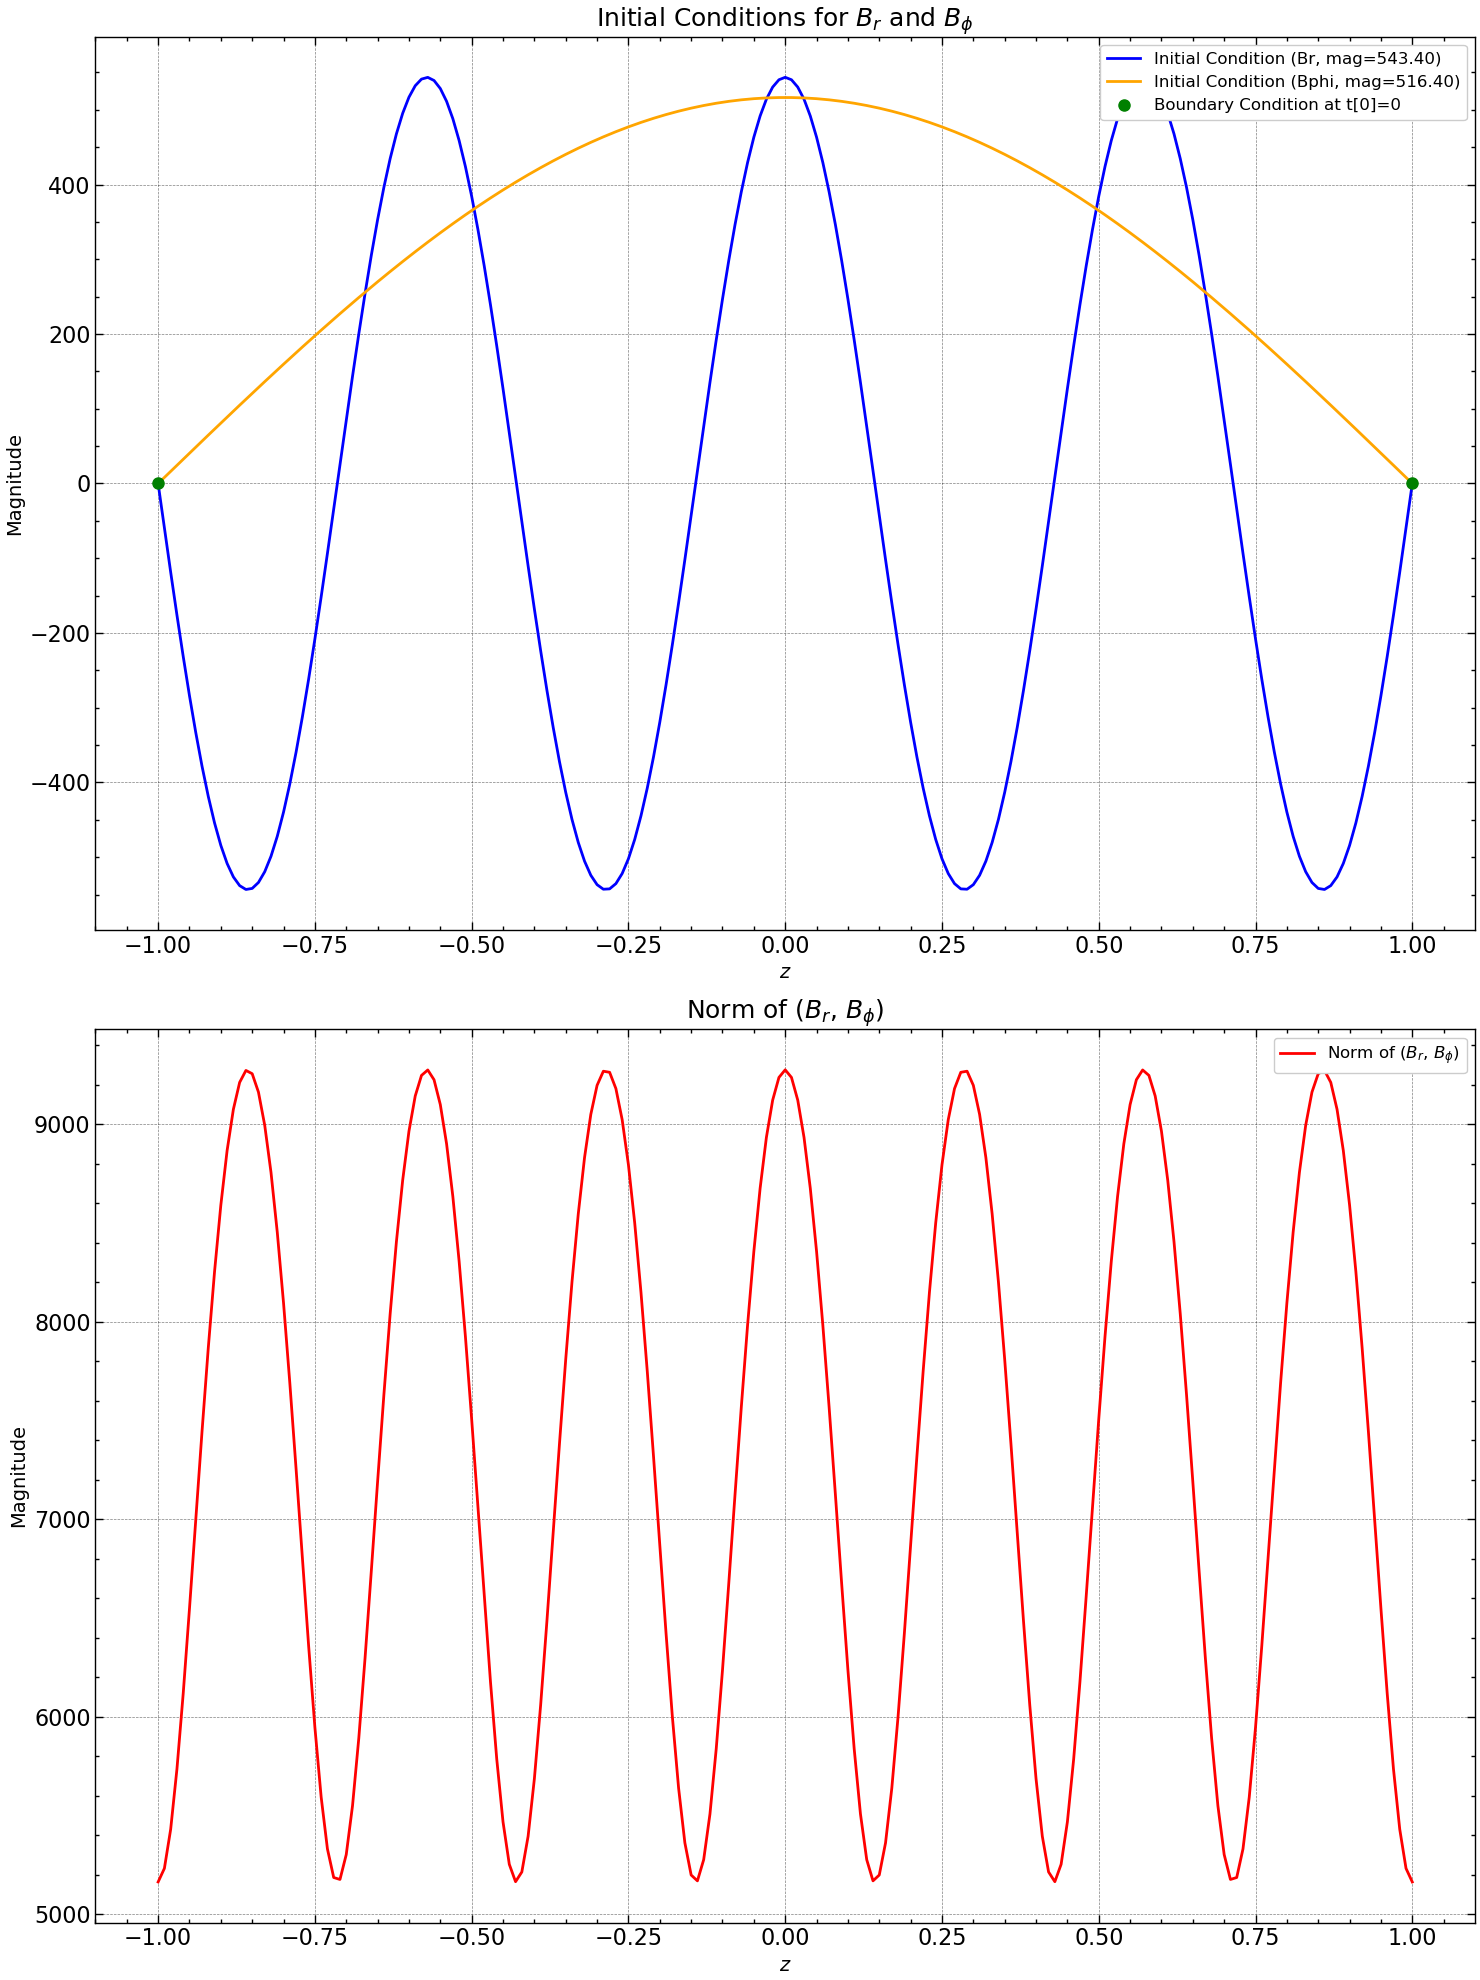

In [8]:
fig, axs = plt.subplots(2, figsize=(15, 20))

axs[0].plot(z, Br[:, 0], label=f'Initial Condition (Br, mag={mag_br:.2f})', color='blue')
axs[0].plot(z, Bphi[:,0], label=f'Initial Condition (Bphi, mag={mag_bphi:.2f})', color='orange')
axs[0].plot(z[[0, N]], Br[[0, N], 0], 'go', markersize=8, label='Boundary Condition at t[0]=0')
axs[0].set_title(r'Initial Conditions for $B_{r}$ and $B_{\phi}$', fontsize=18)
axs[0].set_xlabel(r'$z$', fontsize=14)
axs[0].set_ylabel('Magnitude', fontsize=14)
axs[0].legend(loc='upper right', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)


norm_Br_Bphi = [np.linalg.norm(np.sqrt(Br[i, 0]**2 + Bphi[:,0]**2)) for i in range(len(z))]
axs[1].plot(z, norm_Br_Bphi , label=r'Norm of ($B_r$, $B_{\phi}$)', linestyle='-', color='red')
axs[1].set_title(r'Norm of ($B_{r}$, $B_{\phi}$)', fontsize=18)
axs[1].set_xlabel(r'$z$', fontsize=14)
axs[1].set_ylabel('Magnitude', fontsize=14)
axs[1].legend(loc='upper right', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("results/initial_conditions.png")
plt.show()

## Crank-Nicholson method for Coupled PDEs

We are using Crank-Nicholson difference scheme as done for Task 1, however to extend it to coupled PDEs we will do the following analysis.

Let $\bar{B}_r$ and $\bar{B}_\phi$ be the radial and azimuthal part of magnetic field. Thus,

$$ \frac{\partial B_r}{\partial t} = - \frac{\partial (\alpha B_\phi)}{\partial z} + \eta_T \frac{\partial^2 B_r}{\partial z^2} $$

$$ \frac{\partial B_\phi}{\partial t} = DS B_r + \eta_T \frac{\partial^2 B_phi}{\partial z^2} $$

Lets first discretize equations,

$$ \frac{(B_r)^{j+1}_{i} - (B_r)^{j}_{i}}{k} = - \left. \dfrac{d \alpha}{h}\right \vert_i \left( \frac{(B_\phi)^{j+1}_{i} + (B_\phi)^{j}_{i}}{2} \right) - \dfrac{\alpha_{i}}{2} \: \left( \frac{(B_\phi)^{j+1}_{i+1} - (B_\phi)^{j+1}_{i}}{h} + \frac{(B_\phi)^{j}_{i+1} - (B_\phi)^{j}_{i}}{h} \right) + \dfrac{\eta_T}{2} \: \left( \dfrac{(B_r)^{j+1}_{i+1} - 2(B_r)^{j+1}_{i} + (B_r)^{j+1}_{i-1}}{h^2} + \dfrac{(B_r)^{j}_{i+1} - 2(B_r)^{j}_{i} + (B_r)^{j}_{i-1}}{h^2} \right) $$

and 

$$ \frac{(B_\phi)^{j+1}_{i} - (B_\phi)^{j}_{i}}{k} = DS \left( \frac{(B_r)^{j+1}_{i} + (B_r)^{j}_{i}}{2} \right) + \dfrac{\eta_T}{2} \: \left( \dfrac{(B_\phi)^{j+1}_{i+1} - 2(B_\phi)^{j+1}_{i} + (B_\phi)^{j+1}_{i-1}}{h^2} + \dfrac{(B_\phi)^{j}_{i+1} - 2(B_\phi)^{j}_{i} + (B_\phi)^{j}_{i-1}}{h^2} \right) $$

Putting $\beta = \dfrac{k}{2 \: h}$ and $\beta = \dfrac{\eta_T \: k}{2 \: h^2}$, we separate the present time-step $(j+1)$ and the past time-step $(j)$ as

$$ \left(1+2\beta \right) (B_r)^{j+1}_{i} - \beta  (B_r)^{j+1}_{i+1} - \beta (B_r)^{j+1}_{i-1} + \lambda \alpha_i (B_\phi)^{j+1}_{i+1} + \left( \dfrac{1}{2} \left. \dfrac{d \alpha}{h}\right \vert_i - \lambda \alpha_i \right) (B_\phi)^{j+1}_{i} = \left(1-2\beta \right) (B_r)^{j}_{i} + \beta  (B_r)^{j}_{i+1} + \beta (B_r)^{j}_{i-1} - \lambda \alpha_i (B_\phi)^{j}_{i+1} + \left( - \dfrac{1}{2} \left. \dfrac{d \alpha}{h}\right \vert_i + \lambda \alpha_i \right) (B_\phi)^{j}_{i} $$

and 

$$ \left(1+2\beta \right) (B_\phi)^{j+1}_{i} - \beta  (B_\phi)^{j+1}_{i+1} - \beta (B_\phi)^{j+1}_{i-1} - \dfrac{k \: DS}{2} (B_r)^{j+1}_{i} = \left(1-2\beta \right) (B_\phi)^{j}_{i} + \beta  (B_r)^{j}_{i+1} + \beta (B_r)^{j}_{i-1} + \dfrac{k \: DS}{2} (B_r)^{j}_{i} $$

Let $B = \left[ B_r \:\: B_\phi\right]^T$, This whole coupled equation can be simplified to single variable $B$ as

$$ 
\left[\begin{array}{cc} (1+2 \beta) & \left( \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i - \lambda \alpha_i \right) \\ \dfrac{k \: DS}{2} & (1+2 \beta) \end{array}\right] 
B^{j+1}_{i} + \left[\begin{array}{cc}-\beta & \lambda \\ 0 & -\beta \end{array}\right] B^{j+1}_{i+1} + \left[\begin{array}{cc}-\beta & 0 \\ 0 & -\beta \end{array}\right] B^{j+1}_{i-1} = \left[\begin{array}{cc}(1-2 \beta) & \left( - \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i + \lambda \alpha_i \right) \\ -\dfrac{k \: DS}{2} & (1-2 \beta) \end{array}\right] B^{j}_{i} + \left[\begin{array}{cc}\beta & -\lambda \\ 0 & \beta \end{array}\right] B^{j}_{i+1} + \left[\begin{array}{cc}\beta & 0 \\ 0 & \beta \end{array}\right] B^{j}_{i-1} 
$$

Combining these two expressions as one $2N$ vector transformation, i.e., $B_i^{j}$ where $i = 1, 2, 3, \ldots, 2N$ or $\mathbf{B} = (B_r, B_{\phi})^T$, we can represent the matrix equation as:

$$
T \mathbf{B}_{j+1} = S \mathbf{B}_{j} + \mathbf{b}_{j} + \mathbf{b}_{j+1}
$$

Here, $T$ and $S$ are evolution matrices for the system, and $\mathbf{b}_j$ and $\mathbf{b}_{j+1}$ are column vectors representing the boundary conditions for the current and next time steps, respectively.


$$
\mathcal{T} = \left(
\begin{array}{cc}
\left(
\begin{array}{ccccc}
1+2 \beta & -\beta & 0 & \cdots & 0 \\
-\beta & 1+2 \beta & -\beta & \ddots & \vdots \\
0 & -\beta & 1+2 \beta & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & -\beta \\
0 & \cdots & 0 & -\beta & 1+2 \beta
\end{array}
\right) &
\left(
\begin{array}{ccccc}
\left( \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i - \lambda \alpha_i \right) & \lambda & 0 & \cdots & 0 \\
0 & \left( \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i - \lambda \alpha_i \right) & \lambda & \ddots & \vdots \\
0 & 0 & \left( \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i - \lambda \alpha_i \right) & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & \lambda \\
0 & \cdots & 0 & 0 & \left( \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i - \lambda \alpha_i \right)
\end{array}
\right) \\
& \\
\left(
\begin{array}{ccccc}
\dfrac{k\: DS}{2} & 0 & 0 & \cdots & 0 \\
0 & \dfrac{k\: DS}{2} & 0 & \ddots & \vdots \\
0 & 0 & \dfrac{k\: DS}{2} & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & 0 & \dfrac{k\: DS}{2}
\end{array}
\right) &
\left(
\begin{array}{ccccc}
1+2 \beta & -\beta & 0 & \cdots & 0 \\
-\beta & 1+2 \beta & -\beta & \ddots & \vdots \\
0 & -\beta & 1+2 \beta & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & -\beta \\
0 & \cdots & 0 & -\beta & 1+2 \beta
\end{array}
\right)
\end{array}
\right)
$$

$$
\mathcal{S} = \left(
\begin{array}{cc}
\left(
\begin{array}{ccccc}
1-2 \beta & \beta & 0 & \cdots & 0 \\
\beta & 1-2 \beta & \beta & \ddots & \vdots \\
0 & \beta & 1-2 \beta & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & \beta \\
0 & \cdots & 0 & \beta & 1-2 \beta
\end{array}
\right) &
\left(
\begin{array}{ccccc}
\left( - \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i + \lambda \alpha_i \right) & -\lambda & 0 & \cdots & 0 \\
0 & \left( - \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i + \lambda \alpha_i \right) & -\lambda & \ddots & \vdots \\
0 & 0 & \left( - \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i + \lambda \alpha_i \right) & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & -\lambda \\
0 & \cdots & 0 & 0 & \left( - \dfrac{1}{2} \left. \dfrac{d \alpha}{dz}\right \vert_i + \lambda \alpha_i \right)
\end{array}
\right) \\
& \\
\left(
\begin{array}{ccccc}
-\dfrac{k\: DS}{2} & 0 & 0 & \cdots & 0 \\
0 & -\dfrac{k\: DS}{2} & 0 & \ddots & \vdots \\
0 & 0 & -\dfrac{k\: DS}{2} & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & 0 & -\dfrac{k\: DS}{2}
\end{array}
\right) &
\left(
\begin{array}{ccccc}
1-2 \beta & \beta & 0 & \cdots & 0 \\
\beta & 1-2 \beta & \beta & \ddots & \vdots \\
0 & \beta & 1-2 \beta & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & \beta \\
0 & \cdots & 0 & \beta & 1-2 \beta
\end{array}
\right)
\end{array}
\right)
$$

Or equivalently,

$$ B^{j+1} = \mathcal{T}^{-1}(\mathcal{S}B^{j} + b_j + b_{j-1}) $$

In [9]:
## helper functions

def transfer_matrix(N, a1, a2, a3, a4, b1, b2, b3, b4, c1, c2, c3, c4, alpha, dalpha_dt):
    """
    Get the matrices A and B for solving the diffusion equation using Crank-Nicolson method.
    This function is used for vacuum boundary conditions.

    Parameters:
    - N: Number of spatial grid points
    - a1, b1, ... etc: Coefficients of the matrix
    - alpha: Alpha effect
    - dalpha_dt: Derivative of alpha with respect to time

    Returns:
    - T: Matrix T
    """
    T = np.zeros((2*N, 2*N))
    for i in range(N):
        T[i, i] = a1
        T[i, i+N] = (dalpha_dt[i]/2 - b2*alpha[i])*a2
        T[i+N, i] = a3
        T[i+N, i+N] = a4
    for i in range(N-1):
        T[i, i+1] = b1
        T[i, i+N+1] = b2
        T[i+N, i+1] = b3
        T[i+N, i+N+1] = b4
        T[i+1, i] = c1
        T[i+1, i+N] = c2
        T[i+N+1, i] = c3
        T[i+N+1, i+N] = c4
    return T

def coupled_crank_nicolson_solver(N_x, N_t, init_cond_Br, init_cond_Bphi, A, B):
    
    # Initialize temperature array
    U = np.zeros((2*N_x, N_t))

    # Initial condition
    for i in range(N_x):
        U[i, 0] = init_cond_Br[i]
        U[N_x+i, 0] = init_cond_Bphi[i]

    for j in range(1, N_t):
        U[:, j] = np.dot(np.linalg.inv(A), np.dot(B, U[:, j - 1]))

    return U


def get_decay_rate(x, y):
    # x, y = find_local_maxima(x, y)
    y = np.log(y)
    slope, intercept = np.polyfit(x, y, 1)
    return slope


In [10]:
# Elements of Transfer Matrix
rho = eta_T*dt/(2*dz**2)
sigma = dt/(2*dz)
alpha = alpha_0*np.sin(np.pi*z/2)
dalpha_dt = np.gradient(alpha, z)

In [11]:
A = transfer_matrix(len(z), 1+2*rho, 1, q*Omega*dt/2, 1+2*rho, -rho, sigma, 0, -rho, -rho, 0, 0, -rho, alpha, dalpha_dt)
B = transfer_matrix(len(z), 1-2*rho, -1, -q*Omega*dt/2, 1-2*rho, rho, -sigma, 0, rho, rho, 0, 0, rho, alpha, dalpha_dt)

# Solve the diffusion equation in radial direction
solution = coupled_crank_nicolson_solver(len(z), len(time), Br[:,0], Bphi[:,0], A, B)

Br = solution[:len(z), :]
Bphi = solution[len(z):, :]

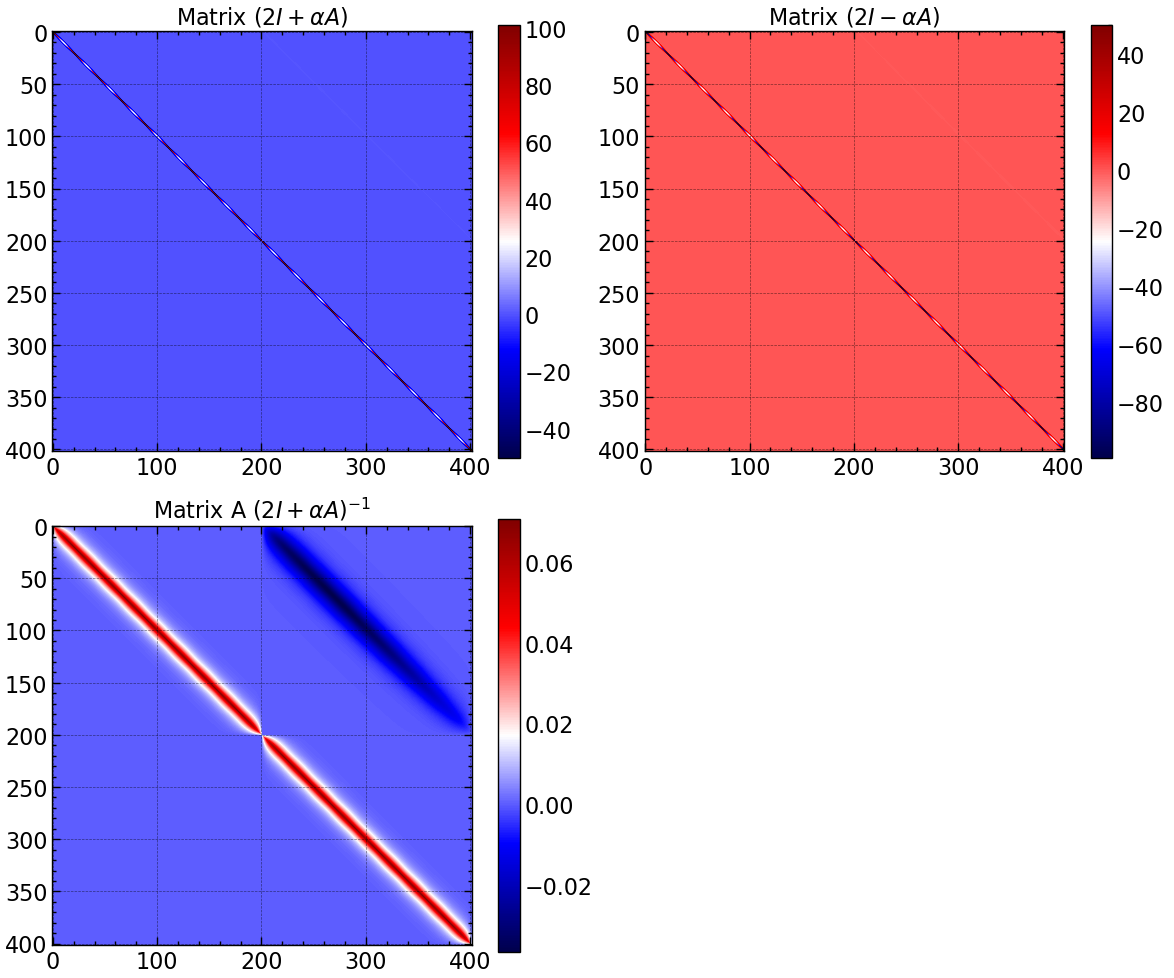

In [12]:
# inverse of A
A_inv = np.linalg.inv(A)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
im = axs[0, 0].imshow(A, cmap='seismic')
axs[0, 0].set_title(r'Matrix $(2I + \alpha A)$')
plt.colorbar(im, ax=axs[0, 0])
im = axs[0, 1].imshow(B, cmap='seismic')
axs[0, 1].set_title(r'Matrix $(2I - \alpha A)$')
plt.colorbar(im, ax=axs[0, 1])
im = axs[1, 0].imshow(A_inv, cmap='seismic')
axs[1, 0].set_title(r'Matrix A $(2I + \alpha A)^{-1}$')
plt.colorbar(im, ax=axs[1, 0])
axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig("results/matrix_A_B_A_inv.png")
plt.show()

### Results @ $|D| \gt |D_c|$

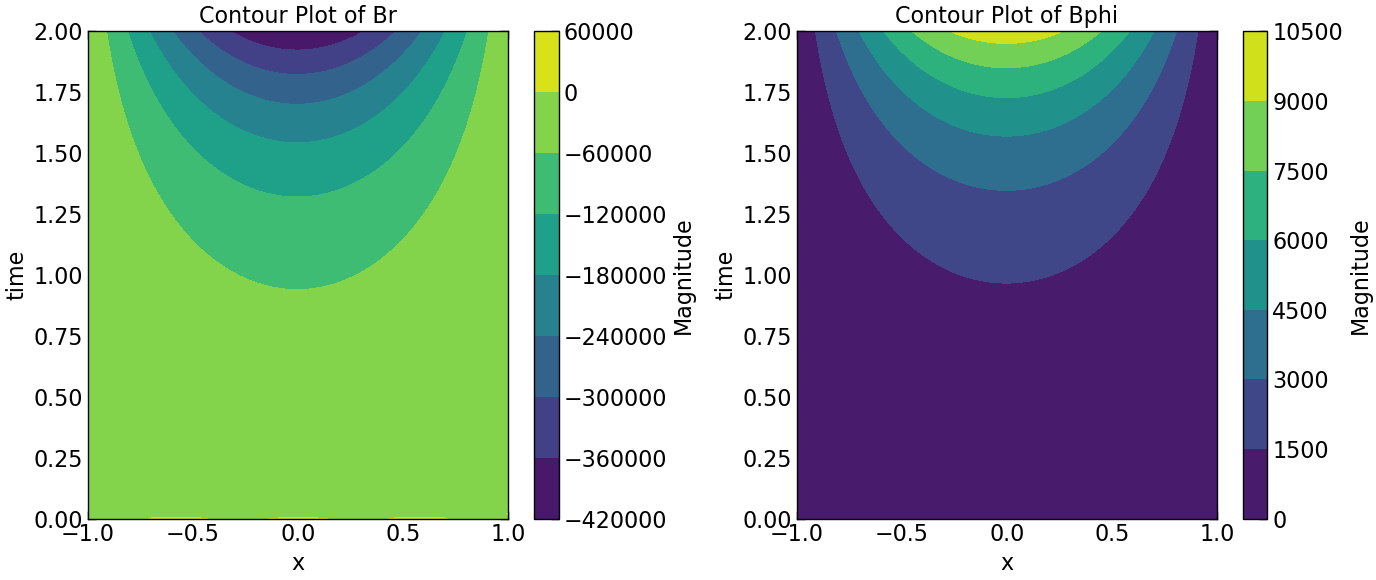

In [13]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.contourf(Z, Y, Br.transpose(), cmap='viridis')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Br')

plt.subplot(1, 2, 2)
plt.contourf(Z, Y, Bphi.transpose(), cmap='viridis')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Bphi')

plt.tight_layout()
plt.savefig("results/contour_plot_Br_Bphi_above_critical_D.png")
plt.show()

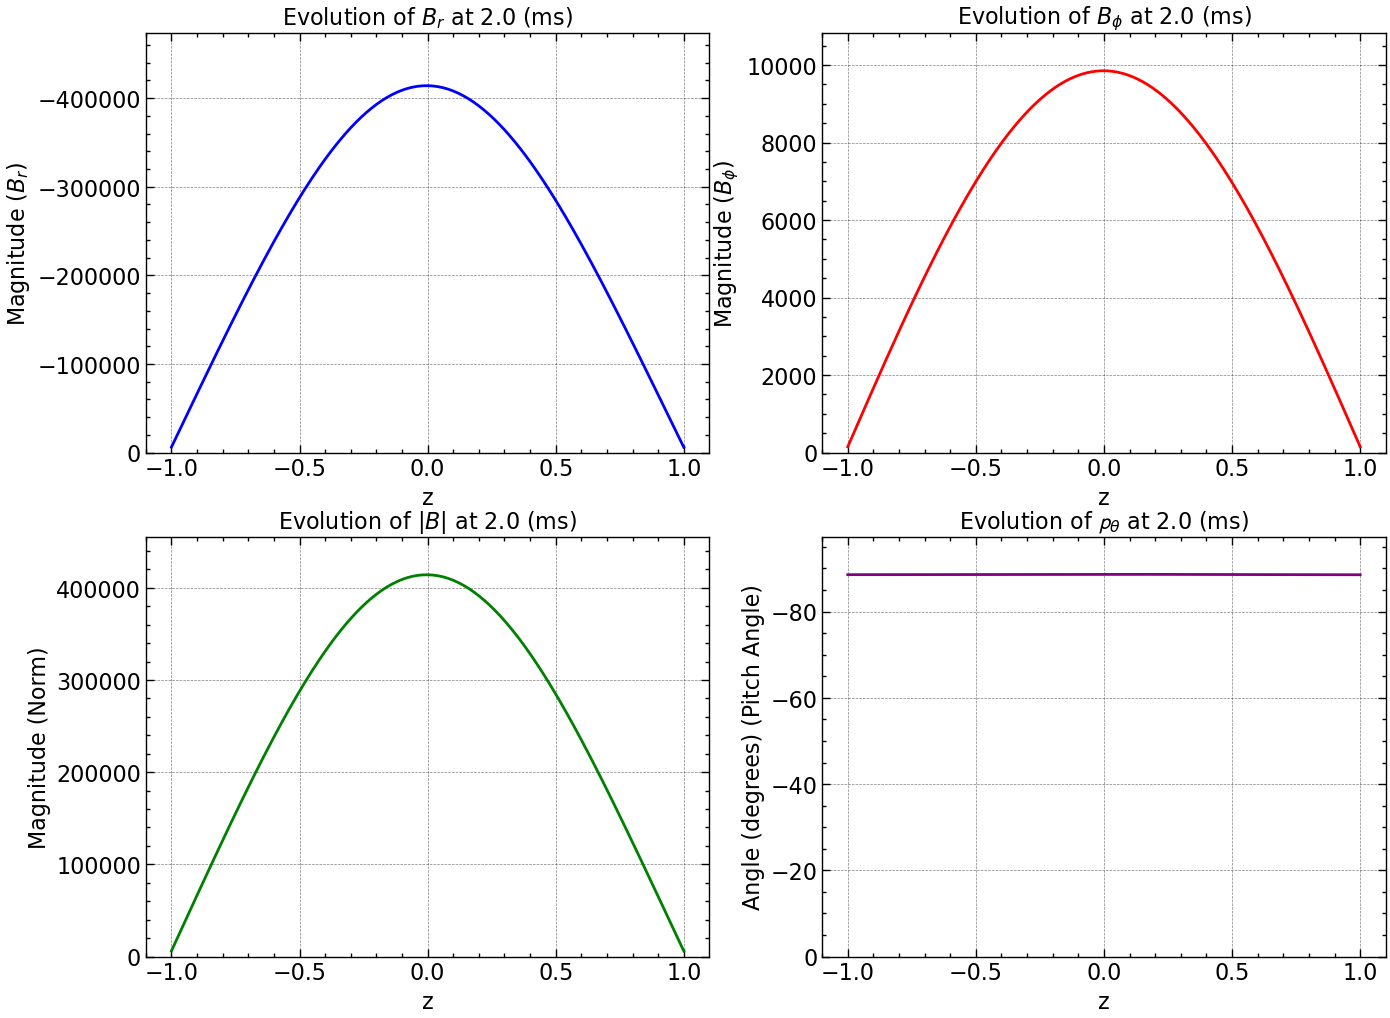

In [14]:
norm_squared_sum = np.sqrt(Br**2 + Bphi**2)
pitch_angle = np.arctan2(Br, Bphi) * (180 / np.pi)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# Plot Br
line_br, = axs[0, 0].plot(np.linspace(-1, 1, Br.shape[0]), Br[:, 0], color='blue', label='Br')
axs[0, 0].set_xlabel('z')
axs[0, 0].set_ylabel('Magnitude')
axs[0, 0].set_title('Evolution of Br')

# Plot Bphi
line_bphi, = axs[0, 1].plot(np.linspace(-1, 1, Bphi.shape[0]), Bphi[:, 0], color='red', label='Bphi')
axs[0, 1].set_xlabel('z')
axs[0, 1].set_ylabel('Magnitude')
axs[0, 1].set_title('Evolution of Bphi')

# Plot Norm
line_norm, = axs[1, 0].plot(np.linspace(-1, 1, norm_squared_sum.shape[0]), norm_squared_sum[:, 0], color='green', label='Norm')
axs[1, 0].set_xlabel('z')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].set_title('Evolution of Norm')


line_pitch, = axs[1, 1].plot(np.linspace(-1, 1, pitch_angle.shape[0]), pitch_angle[:, 0], color='purple', label='Pitch Angle')
axs[1, 1].set_xlabel('z')
axs[1, 1].set_ylabel('Angle (degrees)')
axs[1, 1].set_title('Evolution of Pitch Angle')

def update(frame):
    time = frame * dt
    # Update data for each frame
    Br_data = Br[:, frame]
    Bphi_data = Bphi[:, frame]
    norm_data = norm_squared_sum[:, frame]
    pitch_data = pitch_angle[:, frame]
    
    # Update line data
    line_br.set_ydata(Br_data)
    line_bphi.set_ydata(Bphi_data)
    line_norm.set_ydata(norm_data)
    line_pitch.set_ydata(pitch_data)
    
    # Update y-axis limits based on maximum value of data for each frame
    max_y_br = np.max(Br_data)
    max_y_bphi = np.max(Bphi_data)
    max_y_norm = np.max(norm_data)
    max_y_pitch = np.max(pitch_data)
    
    axs[0, 0].set_ylim(0, max_y_br * 80)  
    axs[0, 1].set_ylim(0, max_y_bphi * 1.1)
    axs[1, 0].set_ylim(0, max_y_norm * 1.1)
    axs[1, 1].set_ylim(0, max_y_pitch * 1.1)
    
    # Update y-axis labels
    axs[0, 0].set_ylabel(r'Magnitude ($B_r$)')
    axs[0, 1].set_ylabel(r'Magnitude ($B_\phi$)')
    axs[1, 0].set_ylabel(r'Magnitude (Norm)')
    axs[1, 1].set_ylabel(r'Angle (degrees) (Pitch Angle)')
    
    # Update titles
    axs[0, 0].set_title(r'Evolution of $B_r$ at %s (ms)' % time)
    axs[0, 1].set_title(r'Evolution of $B_{\phi}$ at %s (ms)' % time)
    axs[1, 0].set_title(r'Evolution of $|B|$ at %s (ms)' % time)
    axs[1, 1].set_title(r'Evolution of $\mathcal{p}_{\theta}$ at %s (ms)' % time)
    
    return line_br, line_bphi, line_norm, line_pitch

ani = FuncAnimation(fig, update, frames=range(Br.shape[1]), interval=100)
ani.save('results/Br_Bphi_Norm_Pitch_evolution_above_critical_D.gif', writer='pillow')

plt.show()

Here is how all the relevant values evolve with time.

![DgtDc](plots/Br_Bphi_Norm_Pitch_evolution_above_critical_D.gif)

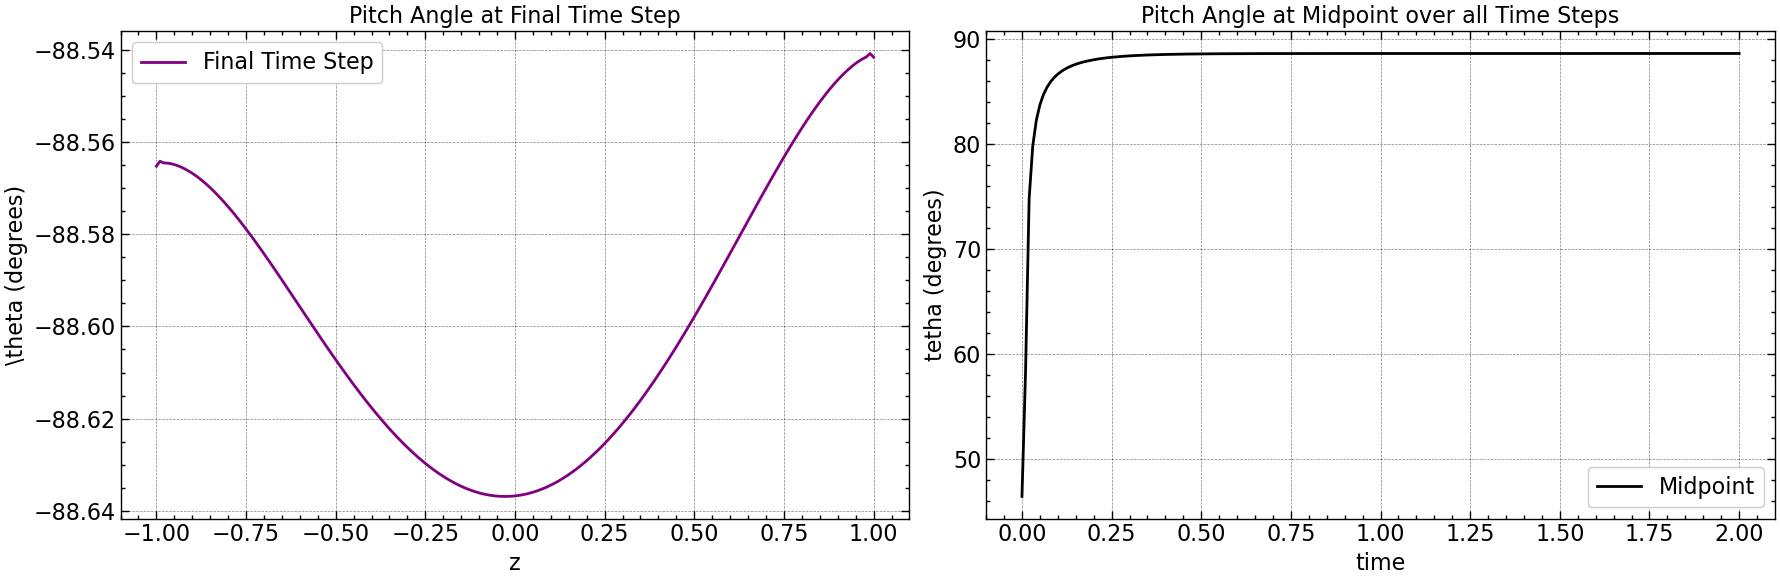

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].plot(np.linspace(-1, 1, pitch_angle.shape[0]), pitch_angle[:, -1], color='purple', label='Final Time Step')
axs[0].set_xlabel(r'z')
axs[0].set_ylabel(r'\theta (degrees)')
axs[0].set_title('Pitch Angle at Final Time Step')
axs[0].legend()
axs[0].grid(True)

midpoint_index = pitch_angle.shape[1] // 2
axs[1].plot(time, np.abs(pitch_angle[midpoint_index, :]), color='black', label='Midpoint')
axs[1].set_xlabel(r'time')
axs[1].set_ylabel(r'tetha (degrees)')
axs[1].set_title('Pitch Angle at Midpoint over all Time Steps')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("results/pitch_angle_comparison.png")
plt.show()

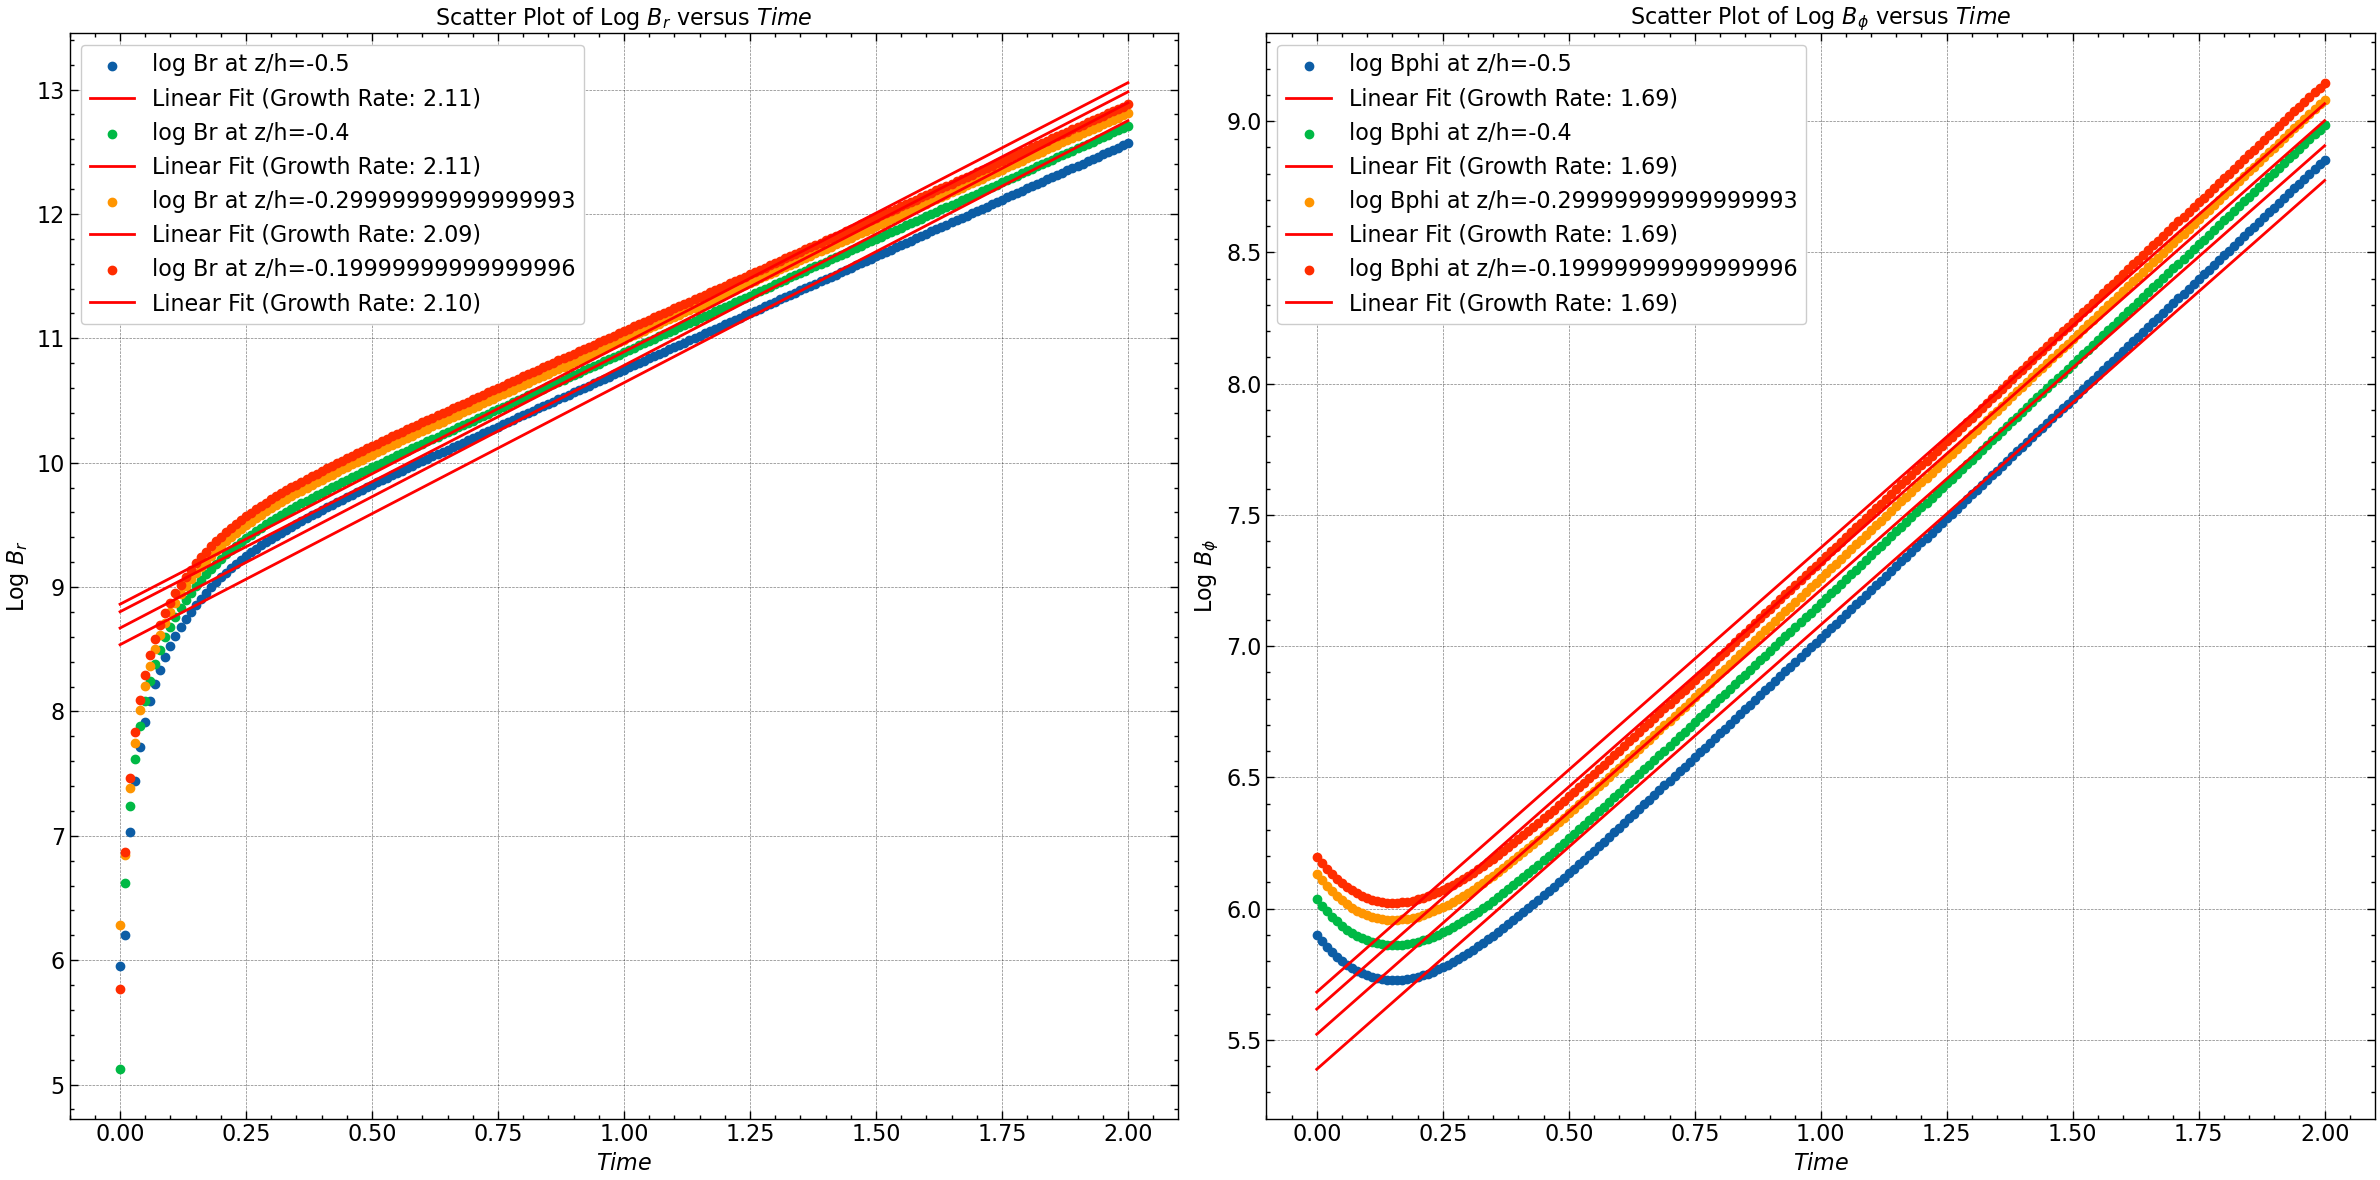

In [16]:
z_indices = [50, 60, 70, 80] 

z_space = np.linspace(-1, 1, Br.shape[0])
selected_Br = Br[z_indices]
selected_Bphi = Bphi[z_indices]

log_Br = np.log(np.abs(selected_Br))
log_Bphi = np.log(np.abs(selected_Bphi))

if len(time) != len(log_Br[0]) or len(time) != len(log_Bphi[0]):
    raise ValueError("Lengths of time array and log arrays do not match.")

fit_Br = [np.polyfit(time, log_Br[i], 1) for i in range(len(z_indices))]
fit_Bphi = [np.polyfit(time, log_Bphi[i], 1) for i in range(len(z_indices))]

# Plotting
plt.figure(figsize=(24, 12))

# Plot for log Br
for i, zi in enumerate(z_indices):
    plt.subplot(1, 2, 1)
    plt.scatter(time, log_Br[i], label=f'log Br at z/h={z_space[zi]}')
    plt.plot(time, np.polyval(fit_Br[i], time), color='red', label=f'Linear Fit (Growth Rate: {fit_Br[i][0]:.2f})')

# Plot for log Bphi
for i, zi in enumerate(z_indices):
    plt.subplot(1, 2, 2)
    plt.scatter(time, log_Bphi[i], label=f'log Bphi at z/h={z_space[zi]}')
    plt.plot(time, np.polyval(fit_Bphi[i], time), color='red', label=f'Linear Fit (Growth Rate: {fit_Bphi[i][0]:.2f})')

plt.subplot(1, 2, 1)
plt.xlabel(r'$Time$')
plt.ylabel(r'Log $B_r$')
plt.title(r'Scatter Plot of Log $B_r$ versus $Time$')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel(r'$Time$')
plt.ylabel(r'Log $B_{\phi}$')
plt.title(r'Scatter Plot of Log $B_{\phi}$ versus $Time$')
plt.legend()

plt.tight_layout()
plt.savefig("results/log_Br_Bphi_vs_time_at_above_Dc.png")
plt.show()

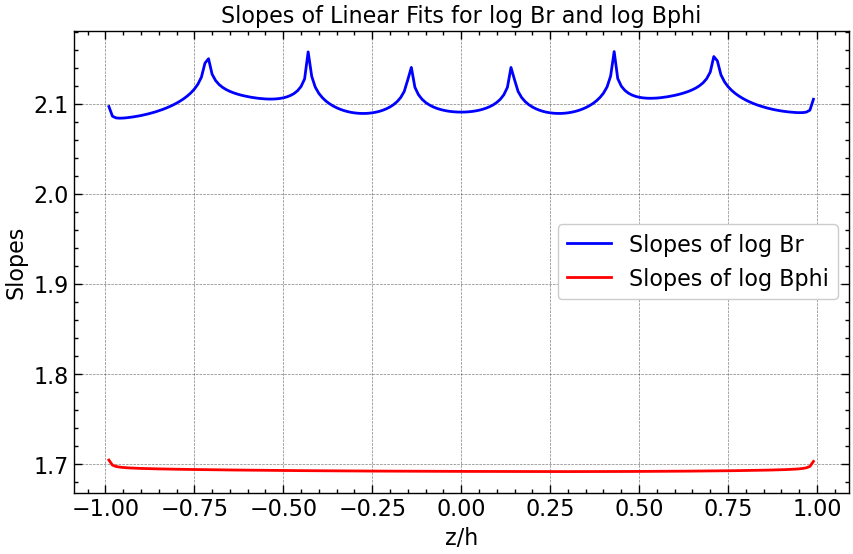

In [17]:
# Compute the logarithm of all Br and Bphi values
log_Br = np.log(np.abs(Br))
log_Bphi = np.log(np.abs(Bphi))

# Perform linear regression on the log Br and log Bphi data to find slopes
slopes_Br = np.zeros(Br.shape[0])  # Initialize array to store slopes of Br
slopes_Bphi = np.zeros(Bphi.shape[0])  # Initialize array to store slopes of Bphi
for i in range(Br.shape[0]):
    fit_Br = np.polyfit(time, log_Br[i, :], 1)
    fit_Bphi = np.polyfit(time, log_Bphi[i, :], 1)
    slopes_Br[i] = fit_Br[0]
    slopes_Bphi[i] = fit_Bphi[0]

# Plotting slopes for all z values
plt.figure(figsize=(10, 6))

plt.plot(z_space, slopes_Br, linestyle='-', color='blue', label='Slopes of log Br')
plt.plot(z_space, slopes_Bphi, linestyle='-', color='red', label='Slopes of log Bphi')

plt.xlabel('z/h')
plt.ylabel('Slopes')
plt.title('Slopes of Linear Fits for log Br and log Bphi')
plt.legend()
plt.grid(True)

plt.savefig("results/slopes_vs_z_above_Dc.png")
plt.show()

## Finding the Critical Dynamo Number by Varying $r$ as $D$ is Inversely Proportional to $r^2$

Finding the critical dynamo number involves a systematic exploration of how the magnetic diffusion coefficient $D$ influences the behavior of the magnetic field in a simulated system. One common approach is to vary $D$ indirectly by adjusting a related parameter, such as the radius ($r$) of the system. Since $D$ is inversely proportional to $r^2$, increasing the radius decreases $D$, and vice versa.

#### Steps to Determine the Critical Dynamo Number:

1. **Parameter Variation:**
   - Vary the radius $r$ of the system while keeping other parameters constant. This effectively changes the magnetic diffusion coefficient $D$.

2. **Simulation Runs:**
   - Perform simulations of the system for each value of $r$.
   - In each simulation, solve the coupled partial differential equations governing the evolution of the magnetic field components $B_r$ and $B_\phi$ numerically over time.

3. **Observation of Behavior:**
   - Observe how the magnetic field evolves over time for each value of $r$.
   - Pay attention to whether the magnetic field undergoes exponential growth, decay, or remains stable.

4. **Identification of Critical Dynamo Number:**
   - Analyze the simulations to identify the smallest radius (or largest $D$ for which the magnetic field exhibits exponential growth.
   - This radius (or corresponding $D$ value) is considered the critical dynamo number for the system.

5. **Validation and Refinement:**
   - Validate the identified critical dynamo number through further simulations or sensitivity analyses.
   - Refine the determination if necessary by adjusting simulation parameters or exploring additional parameter variations.

In [18]:
from scipy.optimize import bisect

# Constants and parameters
h = 8
eta_T = 1  # magnetic diffusivity in (100pc)^2/Myr
Omega = 100 * Myr * km / (1000 * pc)  # angular velocity
q = 1  # shear parameter
alpha_0 = 4/h  # alpha effect

def critical_D(D):
    r = np.sqrt(-alpha_0 * q * Omega * h ** 3 / D) / eta_T

    # Coefficients for the matrix A and B
    rho = eta_T * dt / (2 * dz ** 2)
    sigma = dt / (2 * dz)

    A = transfer_matrix(len(z), 1 + 2 * rho, 1, q * Omega * dt / 2 / r ** 2, 1 + 2 * rho, -rho, sigma, 0, -rho,
                         -rho, 0, 0, -rho, alpha, dalpha_dt)
    B = transfer_matrix(len(z), 1 - 2 * rho, -1, -q * Omega * dt / 2 / r ** 2, 1 - 2 * rho, rho, -sigma, 0, rho,
                         rho, 0, 0, rho, alpha, dalpha_dt)

    # Solve the diffusion equation in radial direction
    solution = coupled_crank_nicolson_solver(len(z), len(time), Br[:, 0], Bphi[:, 0], A, B)

    B_r = solution[:len(z), :]
    B_phi = solution[len(z):, :]
    B_mid_r = B_r[int(len(z) / 2), :]
    B_mid_phi = B_phi[int(len(z) / 2), :]

    B_mid = np.sqrt(B_mid_r ** 2 + B_mid_phi ** 2)

    decay_rate = get_decay_rate(time, B_mid)

    return decay_rate

tol = 1e-3

D_c = bisect(critical_D, -1, -30, xtol=tol)

# Output the result
print('Critical Dynamo number Dc =', np.round(2*D_c, 4))
print('Thus at r =', np.round(np.sqrt(-alpha_0 * q * Omega * h ** 3 / D_c) / eta_T, 4), 'Kpc')


Critical Dynamo number Dc = -10.5191
Thus at r = 2.2302 Kpc


### Results @ $|D| \lt |D_c|$

In [19]:
# Parameters 
h = 7                               # 100pc
eta_T = 2                           # magnetic diffusivity 
Omega = 100*Myr*km/(1000*pc)        # angular velocity
q = 1                               # shear paramete
alpha_0 = 4/h                       # alpha effect

In [20]:
data = [
    ['Parameter', 'Value'],
    ['eta', eta_T],
    ['alpha', alpha_0],
    ['omega', Omega],
    ['Rw', -q*Omega*h**2/eta_T],
    ['Ra', alpha_0*h/eta_T],
    ['Dynamo number', -alpha_0*q*Omega*h**3/eta_T**2]
]

print(tabulate(data, tablefmt='fancy_grid'))

╒═══════════════╤═════════════════════╕
│ Parameter     │ Value               │
├───────────────┼─────────────────────┤
│ eta           │ 2                   │
├───────────────┼─────────────────────┤
│ alpha         │ 0.5714285714285714  │
├───────────────┼─────────────────────┤
│ omega         │ 0.10219053791315619 │
├───────────────┼─────────────────────┤
│ Rw            │ -2.5036681788723265 │
├───────────────┼─────────────────────┤
│ Ra            │ 2.0                 │
├───────────────┼─────────────────────┤
│ Dynamo number │ -5.007336357744653  │
╘═══════════════╧═════════════════════╛


In [21]:
# Elements of Transfer Matrix
rho = eta_T*dt/(2*dz**2)
sigma = dt/(2*dz)
alpha = alpha_0*np.sin(np.pi*z/2)
dalpha_dt = np.gradient(alpha, z)

In [22]:
A = transfer_matrix(len(z), 1+2*rho, 1, q*Omega*dt/2, 1+2*rho, -rho, sigma, 0, -rho, -rho, 0, 0, -rho, alpha, dalpha_dt)
B = transfer_matrix(len(z), 1-2*rho, -1, -q*Omega*dt/2, 1-2*rho, rho, -sigma, 0, rho, rho, 0, 0, rho, alpha, dalpha_dt)

# Solve the diffusion equation in radial direction
solution = coupled_crank_nicolson_solver(len(z), len(time), Br[:,0], Bphi[:,0], A, B)

Br = solution[:len(z), :]
Bphi = solution[len(z):, :]

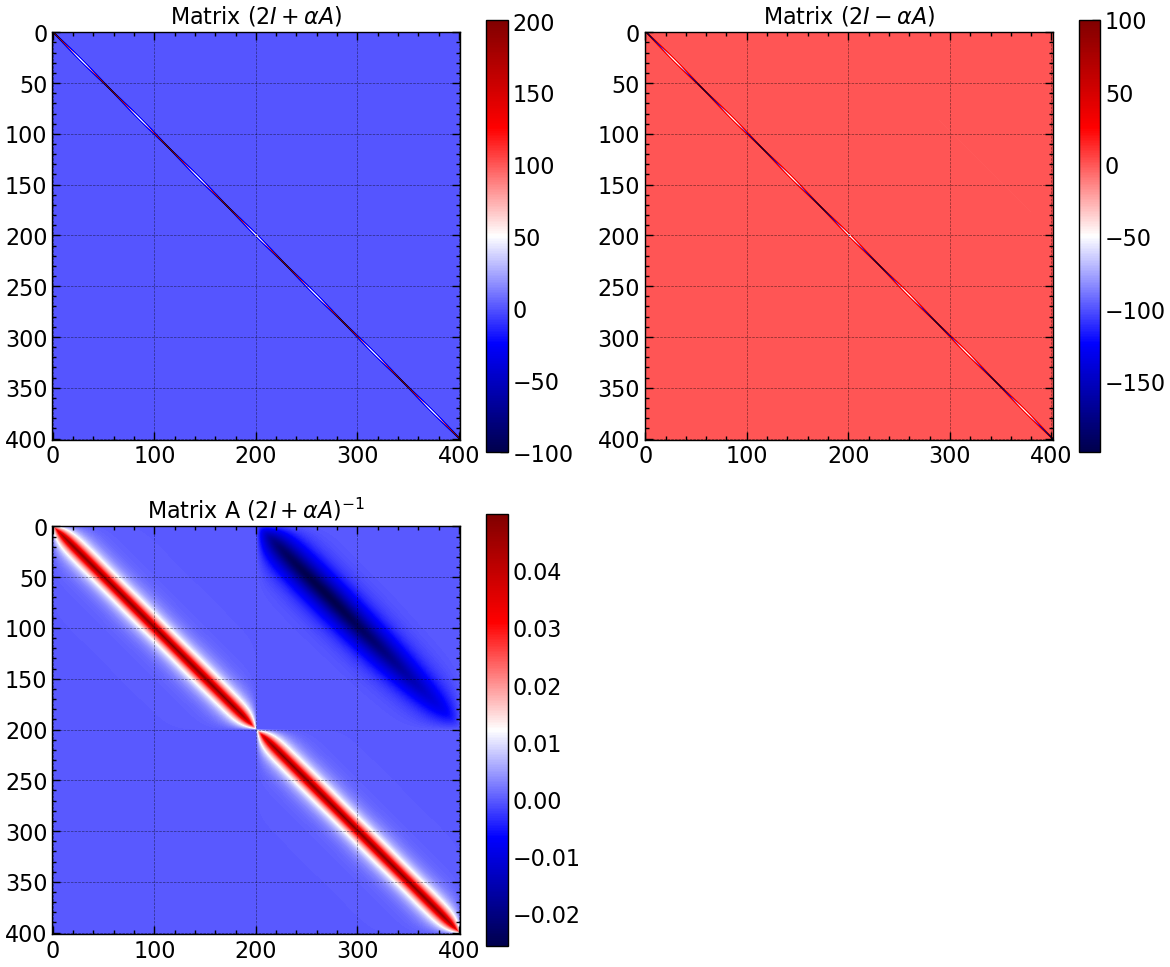

In [23]:
# inverse of A
A_inv = np.linalg.inv(A)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
im = axs[0, 0].imshow(A, cmap='seismic')
axs[0, 0].set_title(r'Matrix $(2I + \alpha A)$')
plt.colorbar(im, ax=axs[0, 0])
im = axs[0, 1].imshow(B, cmap='seismic')
axs[0, 1].set_title(r'Matrix $(2I - \alpha A)$')
plt.colorbar(im, ax=axs[0, 1])
im = axs[1, 0].imshow(A_inv, cmap='seismic')
axs[1, 0].set_title(r'Matrix A $(2I + \alpha A)^{-1}$')
plt.colorbar(im, ax=axs[1, 0])
axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig("results/matrix_A_B_A_inv.pdf")
plt.show()

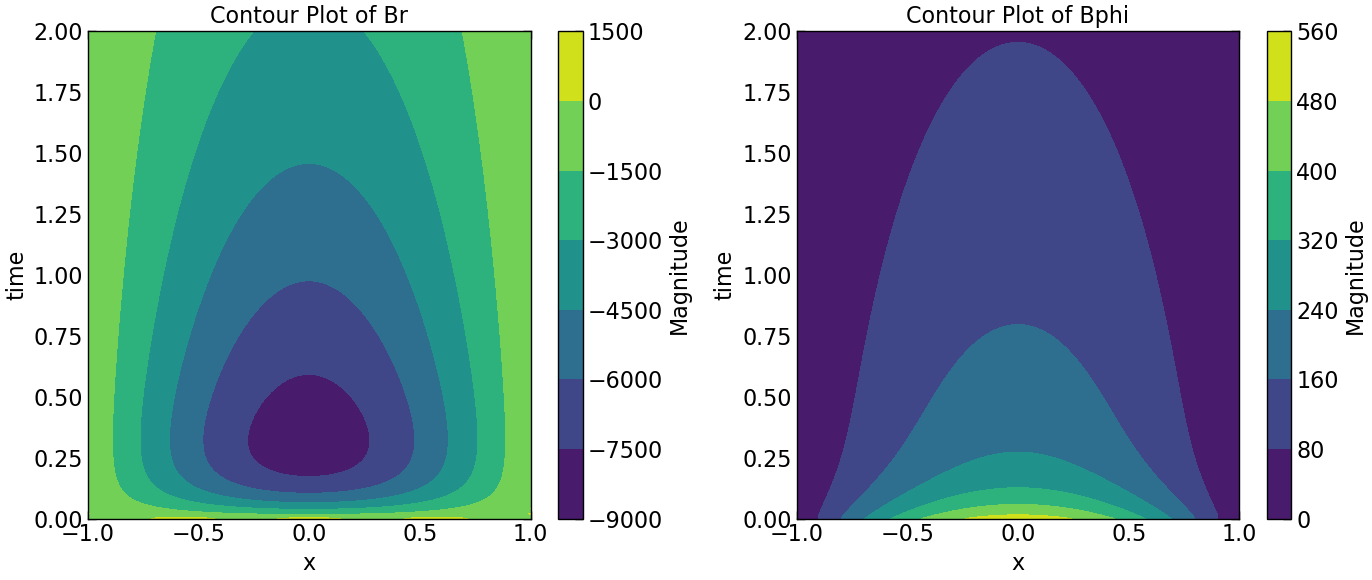

In [24]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.contourf(Z, Y, Br.transpose(), cmap='viridis')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Br')

plt.subplot(1, 2, 2)
plt.contourf(Z, Y, Bphi.transpose(), cmap='viridis')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Bphi')

plt.tight_layout()
plt.savefig("results/contour_plot_Br_Bphi_above_below_D.png")
plt.show()

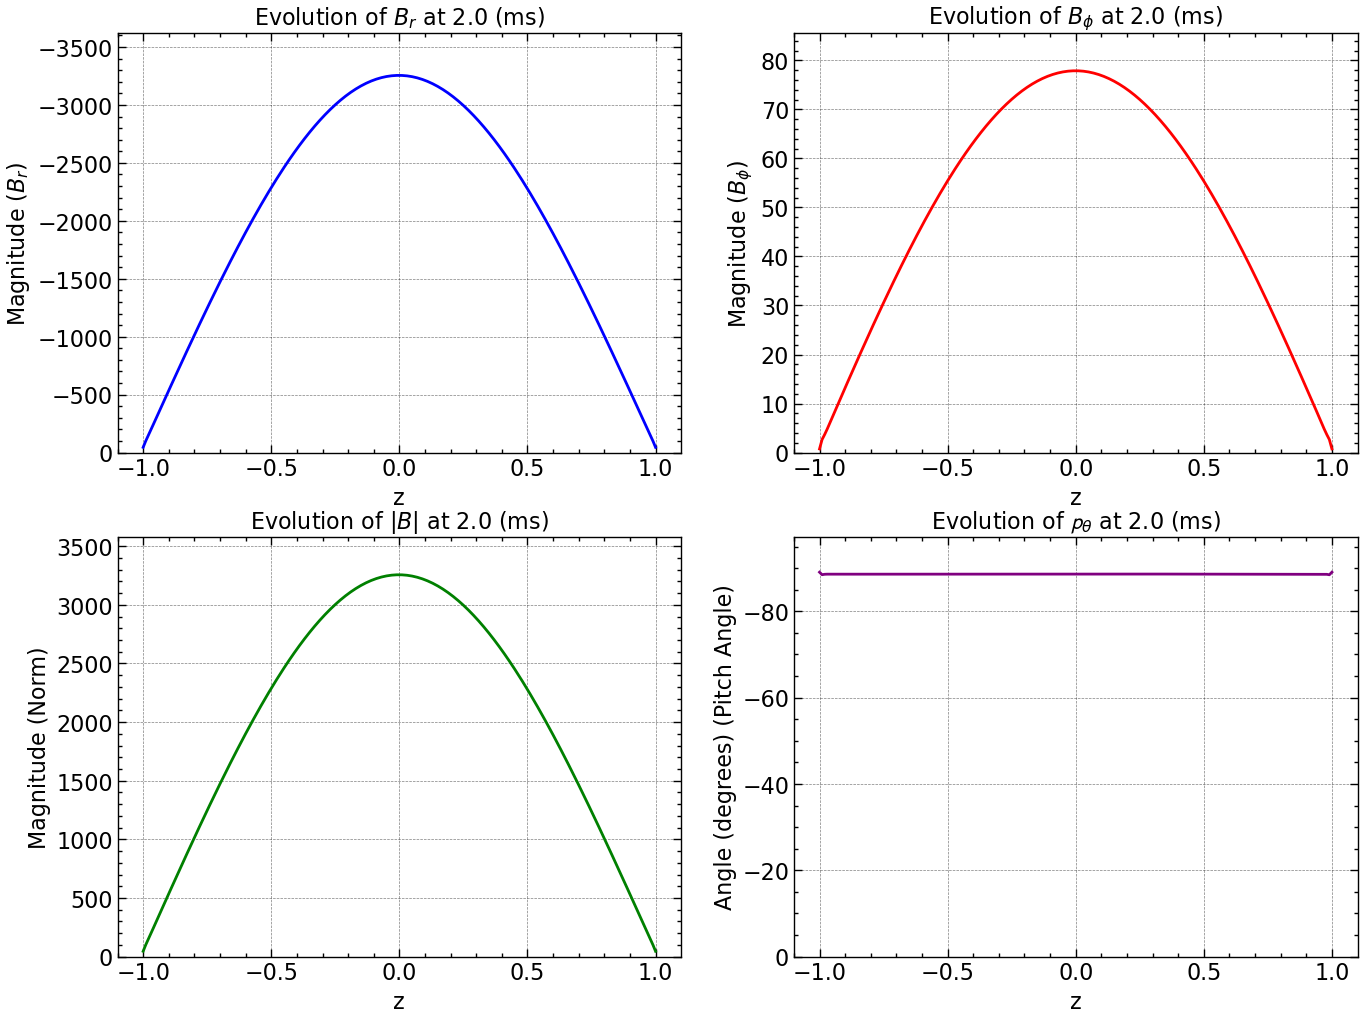

In [25]:
norm_squared_sum = np.sqrt(Br**2 + Bphi**2)
pitch_angle = np.arctan2(Br, Bphi) * (180 / np.pi)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# Plot Br
line_br, = axs[0, 0].plot(np.linspace(-1, 1, Br.shape[0]), Br[:, 0], color='blue', label='Br')
axs[0, 0].set_xlabel('z')
axs[0, 0].set_ylabel('Magnitude')
axs[0, 0].set_title('Evolution of Br')

# Plot Bphi
line_bphi, = axs[0, 1].plot(np.linspace(-1, 1, Bphi.shape[0]), Bphi[:, 0], color='red', label='Bphi')
axs[0, 1].set_xlabel('z')
axs[0, 1].set_ylabel('Magnitude')
axs[0, 1].set_title('Evolution of Bphi')

# Plot Norm
line_norm, = axs[1, 0].plot(np.linspace(-1, 1, norm_squared_sum.shape[0]), norm_squared_sum[:, 0], color='green', label='Norm')
axs[1, 0].set_xlabel('z')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].set_title('Evolution of Norm')


line_pitch, = axs[1, 1].plot(np.linspace(-1, 1, pitch_angle.shape[0]), pitch_angle[:, 0], color='purple', label='Pitch Angle')
axs[1, 1].set_xlabel('z')
axs[1, 1].set_ylabel('Angle (degrees)')
axs[1, 1].set_title('Evolution of Pitch Angle')

def update(frame):
    time = frame * dt
    # Update data for each frame
    Br_data = Br[:, frame]
    Bphi_data = Bphi[:, frame]
    norm_data = norm_squared_sum[:, frame]
    pitch_data = pitch_angle[:, frame]
    
    # Update line data
    line_br.set_ydata(Br_data)
    line_bphi.set_ydata(Bphi_data)
    line_norm.set_ydata(norm_data)
    line_pitch.set_ydata(pitch_data)
    
    # Update y-axis limits based on maximum value of data for each frame
    max_y_br = np.max(Br_data)
    max_y_bphi = np.max(Bphi_data)
    max_y_norm = np.max(norm_data)
    max_y_pitch = np.max(pitch_data)
    
    axs[0, 0].set_ylim(0, max_y_br * 80)  
    axs[0, 1].set_ylim(0, max_y_bphi * 1.1)
    axs[1, 0].set_ylim(0, max_y_norm * 1.1)
    axs[1, 1].set_ylim(0, max_y_pitch * 1.1)
    
    # Update y-axis labels
    axs[0, 0].set_ylabel(r'Magnitude ($B_r$)')
    axs[0, 1].set_ylabel(r'Magnitude ($B_\phi$)')
    axs[1, 0].set_ylabel(r'Magnitude (Norm)')
    axs[1, 1].set_ylabel(r'Angle (degrees) (Pitch Angle)')
    
    # Update titles
    axs[0, 0].set_title(r'Evolution of $B_r$ at %s (ms)' % time)
    axs[0, 1].set_title(r'Evolution of $B_{\phi}$ at %s (ms)' % time)
    axs[1, 0].set_title(r'Evolution of $|B|$ at %s (ms)' % time)
    axs[1, 1].set_title(r'Evolution of $\mathcal{p}_{\theta}$ at %s (ms)' % time)
    
    return line_br, line_bphi, line_norm, line_pitch

ani = FuncAnimation(fig, update, frames=range(Br.shape[1]), interval=100)
ani.save('results/Br_Bphi_Norm_Pitch_evolution_below_critical_D.gif', writer='pillow')

plt.show()

Here is how all the relevant values evolve with time.

![DgtDc](plots/Br_Bphi_Norm_Pitch_evolution_below_critical_D.gif)

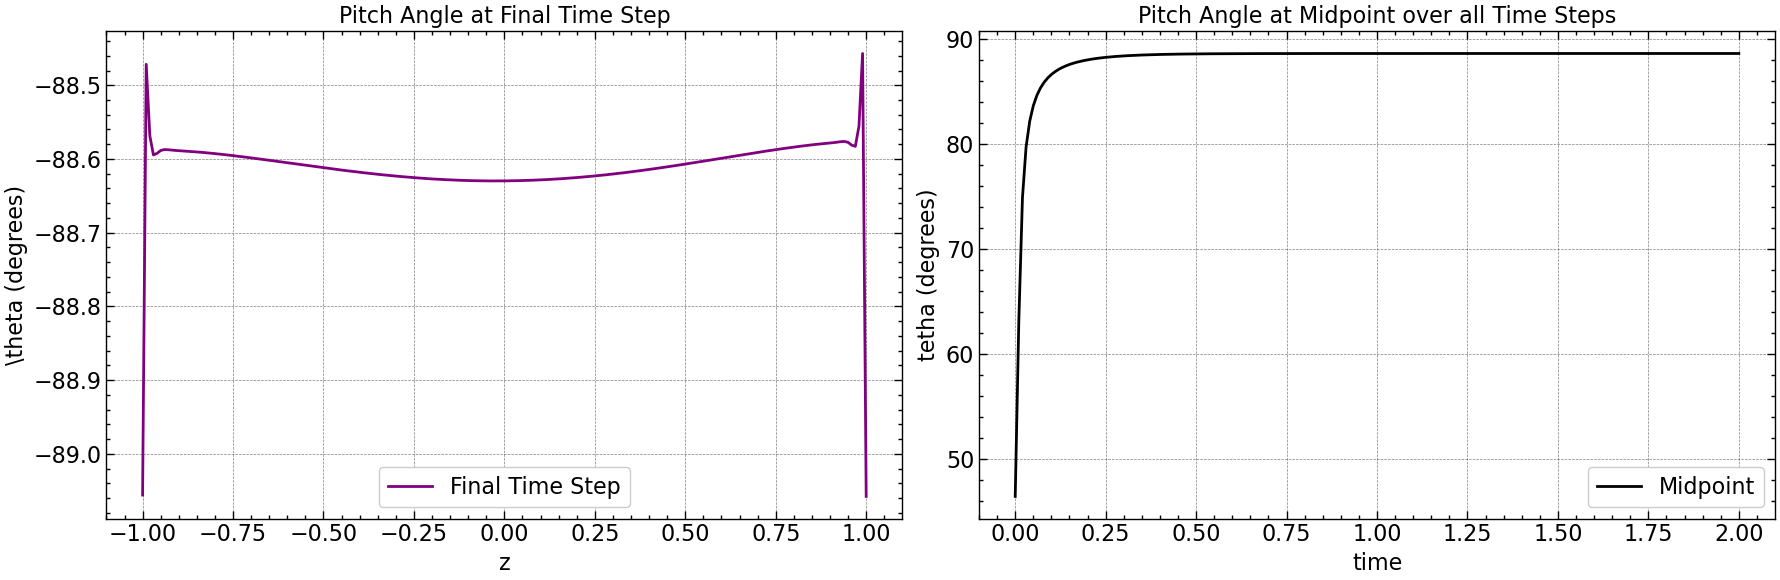

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].plot(np.linspace(-1, 1, pitch_angle.shape[0]), pitch_angle[:, -1], color='purple', label='Final Time Step')
axs[0].set_xlabel(r'z')
axs[0].set_ylabel(r'\theta (degrees)')
axs[0].set_title('Pitch Angle at Final Time Step')
axs[0].legend()
axs[0].grid(True)

midpoint_index = pitch_angle.shape[1] // 2
axs[1].plot(time, np.abs(pitch_angle[midpoint_index, :]), color='black', label='Midpoint')
axs[1].set_xlabel(r'time')
axs[1].set_ylabel(r'tetha (degrees)')
axs[1].set_title('Pitch Angle at Midpoint over all Time Steps')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("results/pitch_angle_comparison_below_Dc.png")
plt.show()

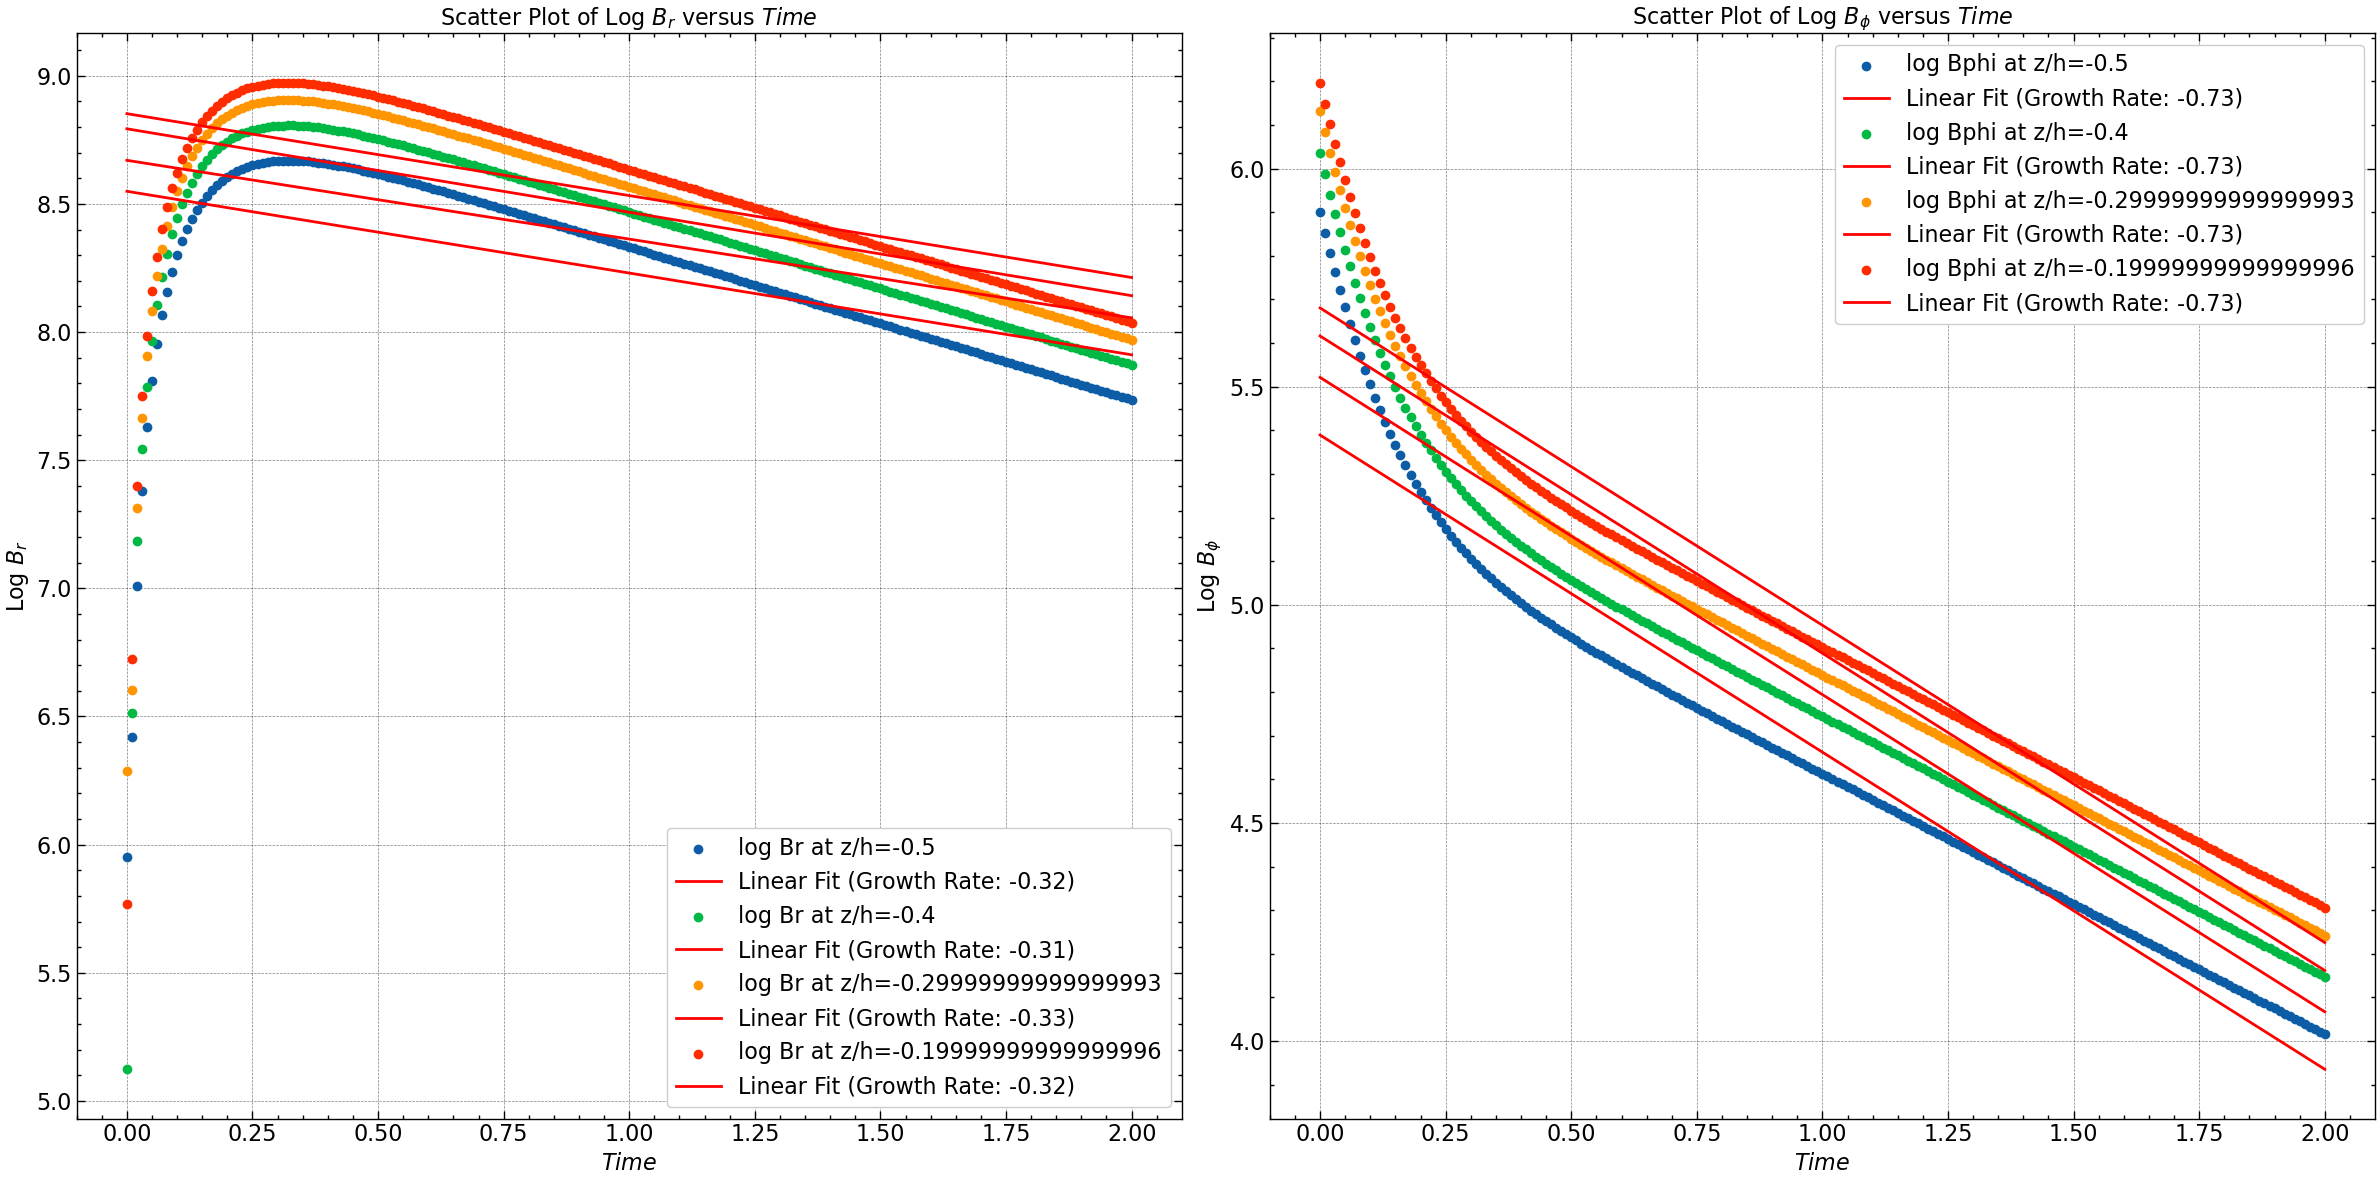

In [27]:
z_values = [50, 60, 70, 80] 

z_space = np.linspace(-1, 1, Br.shape[0])
selected_Br = Br[z_values]
selected_Bphi = Bphi[z_values]

log_Br = np.log(np.abs(selected_Br))
log_Bphi = np.log(np.abs(selected_Bphi))

if len(time) != len(log_Br[0]) or len(time) != len(log_Bphi[0]):
    raise ValueError("Lengths of time array and log arrays do not match.")

fit_Br = [np.polyfit(time, log_Br[i], 1) for i in range(len(z_values))]
fit_Bphi = [np.polyfit(time, log_Bphi[i], 1) for i in range(len(z_values))]

# Plotting
plt.figure(figsize=(24, 12))

# Plot for log Br
for i, z in enumerate(z_values):
    plt.subplot(1, 2, 1)
    plt.scatter(time, log_Br[i], label=f'log Br at z/h={z_space[z]}')
    plt.plot(time, np.polyval(fit_Br[i], time), color='red', label=f'Linear Fit (Growth Rate: {fit_Br[i][0]:.2f})')

# Plot for log Bphi
for i, z in enumerate(z_values):
    plt.subplot(1, 2, 2)
    plt.scatter(time, log_Bphi[i], label=f'log Bphi at z/h={z_space[z]}')
    plt.plot(time, np.polyval(fit_Bphi[i], time), color='red', label=f'Linear Fit (Growth Rate: {fit_Bphi[i][0]:.2f})')

plt.subplot(1, 2, 1)
plt.xlabel(r'$Time$')
plt.ylabel(r'Log $B_r$')
plt.title(r'Scatter Plot of Log $B_r$ versus $Time$')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel(r'$Time$')
plt.ylabel(r'Log $B_{\phi}$')
plt.title(r'Scatter Plot of Log $B_{\phi}$ versus $Time$')
plt.legend()

plt.tight_layout()
plt.savefig("results/log_Br_Bphi_vs_time_at_below_Dc.png")
plt.show()

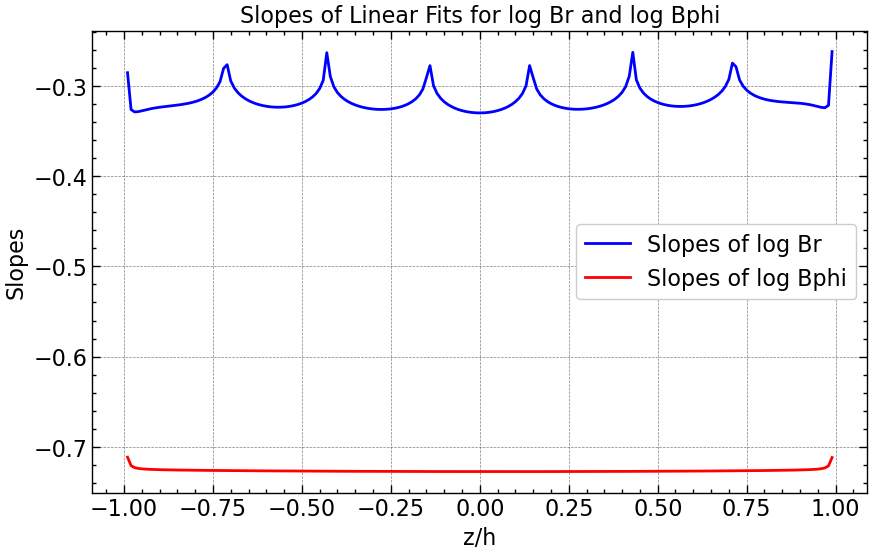

In [28]:
# Compute the logarithm of all Br and Bphi values
log_Br = np.log(np.abs(Br))
log_Bphi = np.log(np.abs(Bphi))

# Perform linear regression on the log Br and log Bphi data to find slopes
slopes_Br = np.zeros(Br.shape[0])  # Initialize array to store slopes of Br
slopes_Bphi = np.zeros(Bphi.shape[0])  # Initialize array to store slopes of Bphi
for i in range(Br.shape[0]):
    fit_Br = np.polyfit(time, log_Br[i, :], 1)
    fit_Bphi = np.polyfit(time, log_Bphi[i, :], 1)
    slopes_Br[i] = fit_Br[0]
    slopes_Bphi[i] = fit_Bphi[0]

# Plotting slopes for all z values
plt.figure(figsize=(10, 6))

plt.plot(z_space, slopes_Br, linestyle='-', color='blue', label='Slopes of log Br')
plt.plot(z_space, slopes_Bphi, linestyle='-', color='red', label='Slopes of log Bphi')

plt.xlabel('z/h')
plt.ylabel('Slopes')
plt.title('Slopes of Linear Fits for log Br and log Bphi')
plt.legend()
plt.grid(True)

plt.savefig("results/slopes_vs_z_below_Dc.png")
plt.show()